Experimenting with new visualisations & features

---

In [1]:
from pathlib import Path
import os
_cwd = os.getcwd()from pathlib import Path
import os
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..') # .\SAE\
os.getcwd()
fig_path = Path("./figures/")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

import numpy as np
import torch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

%matplotlib inline

# ------- internal imports
from models import GenerativeAE
import models, metrics, experiments, datasets
from metrics import score_disentanglement 
from experiments import EvaluationManager
from experiments.EvaluationManager import ModelHandler, VisualModelHandler, VectorModelHandler
from datasets import synth_dataset 
import visualisations
from visualisations import visualise_data, visualise_model

In [33]:
import importlib
importlib.reload(experiments)
importlib.reload(sns)

importlib.reload(metrics)
importlib.reload(datasets)
importlib.reload(models)
importlib.reload(score_disentanglement)
importlib.reload(visualise_data)
importlib.reload(EvaluationManager)

<module 'experiments.EvaluationManager' from 'C:\\Users\\Giulia\\Study\\projects\\research\\SAE\\experiments\\EvaluationManager.py'>

## Testing Evaluation Manager new features

In [ ]:
#handler.model.cpu()
scores = handler.score_model(FID=False, disentanglement=True, orthogonality=True)

In [ ]:
scores

In [ ]:
scores['extra_disentanglement'] =None

In [ ]:
import json
base_path = Path(handler.config['logging_params']['save_dir']) / \
                        handler.config['logging_params']['name'] / \
                        handler.config['logging_params']['version'] / "scoring.json"
with open(base_path, 'w') as o:
    json.dump(scores, o)

In [ ]:
plots = handler.plot_model(do_originals=True, do_reconstructions=True, do_random_samples=True, do_traversals=True)

In [ ]:
plots["random_samples"]

---

In [8]:
handler = VisualModelHandler.from_config(model_name="BaseSAE", model_version="standardS", data="MNIST")

configs/models/BaseSAE/standardS.yaml
BaseSAE model hanlder loaded.


In [9]:
handler.load_checkpoint("final")

Loading selected checkpoint at logs\BaseSAE\standardS_MNIST\checkpoints/final.ckpt
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        MaxPool2d-11             [-1, 32, 7, 7]               0
             Mish-12             [-1, 32, 7, 7]               0
      

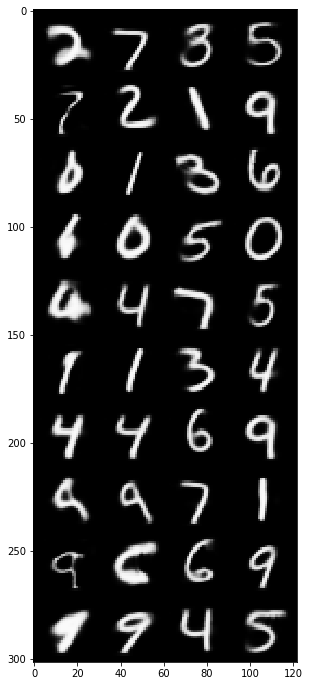

In [12]:
res = handler.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=False)
fig = res['hybrids']
#fname = fig_path / "hybridsLowSae.png"
#fig.savefig(fname)

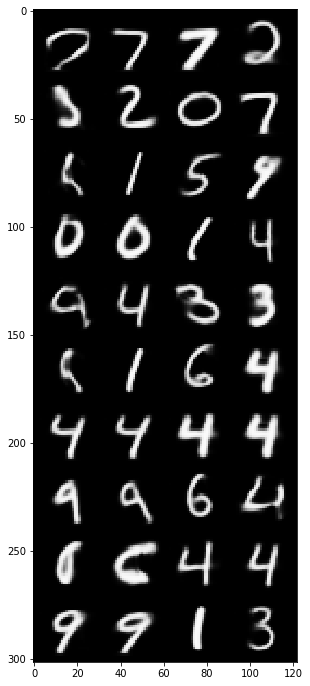

In [13]:
res = handler.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=True)
fig = res['hybrids']
#fname = fig_path / "hybridsHighSae.png"
#fig.savefig(fname)

In [10]:
handlerESAE = VisualModelHandler.from_config(model_name="ESAE", model_version="standardS", data="MNIST")

configs/models/ESAE/standardS.yaml
ESAE model hanlder loaded.


In [11]:
handlerESAE.load_checkpoint()

Loading latest checkpoint at logs\ESAE\standardS_MNIST\checkpoints\epoch=249-step=82120.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        MaxPool2d-11             [-1, 32, 7, 7]               0
             Mish-12             [-1, 32, 7, 7]           

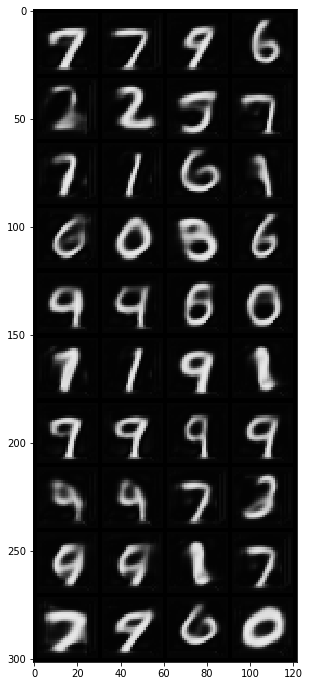

In [18]:
res = handlerESAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=False)
fig = res['hybrids']
#fname = fig_path / "hybridsLowESAE.png"
#fig.savefig(fname)

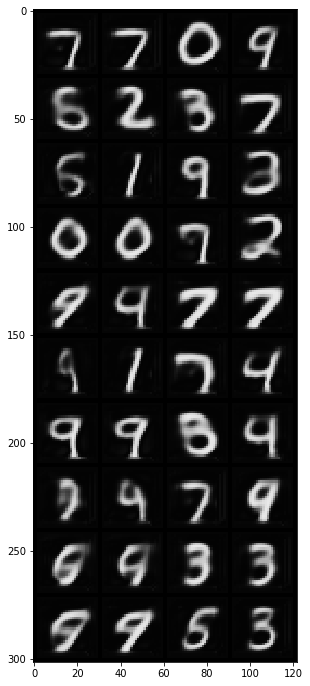

In [19]:
res = handlerESAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=True)
fig = res['hybrids']
#fname = fig_path / "hybridsHighESAE.png"
#fig.savefig(fname)

In [12]:
handlerVAE = VisualModelHandler.from_config(model_name="BetaVAE", model_version="standard", data="MNIST")
handlerVAE.load_checkpoint()

BetaVAE model hanlder loaded.
Loading latest checkpoint at logs\BetaVAE\standard_MNIST\checkpoints\final.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
         MaxPool2d-2           [-1, 64, 14, 14]               0
              Mish-3           [-1, 64, 14, 14]               0
       BatchNorm2d-4           [-1, 64, 14, 14]             128
         ConvBlock-5           [-1, 64, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          36,928
              Mish-7           [-1, 64, 14, 14]               0
       BatchNorm2d-8           [-1, 64, 14, 14]             128
         ConvBlock-9           [-1, 64, 14, 14]               0
           Conv2d-10           [-1, 64, 14, 14]          36,928
        MaxPool2d-11             [-1, 64, 7, 7]               0
             Mish-12             [-1, 64,

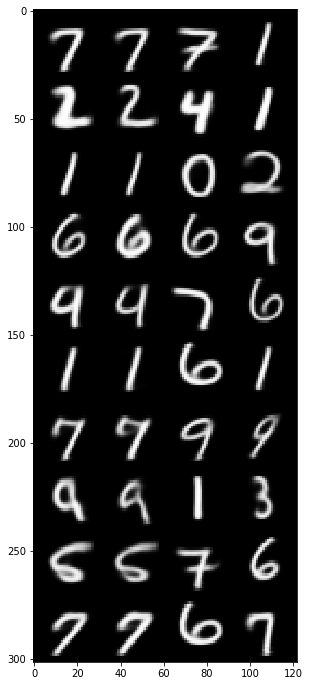

In [15]:
res = handlerVAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=True)
fig = res['hybrids']
fname = fig_path / "hybridsHighVAE.png"
fig.savefig(fname)

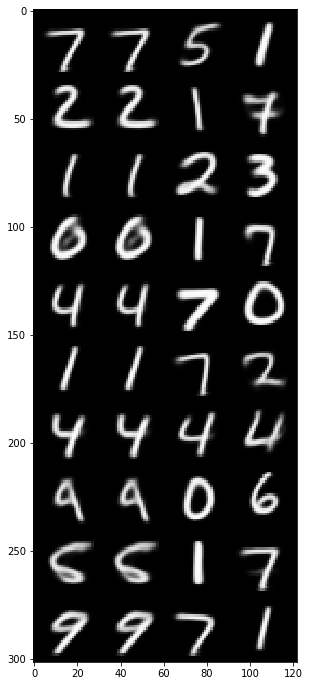

In [18]:
res = handlerVAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=False)
fig = res['hybrids']
fname = fig_path / "hybridsLowVAE.png"
fig.savefig(fname)

In [13]:
handlerRSAE = VisualModelHandler.from_config(model_name="RSAE", model_version="standardS", data="MNIST")
handlerRSAE.load_checkpoint()

configs/models/RSAE/standardS.yaml
RSAE model hanlder loaded.
Loading latest checkpoint at logs\RSAE\standardS_MNIST\checkpoints\final.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        MaxPool2d-11             [-1, 32, 7, 7]               0
           

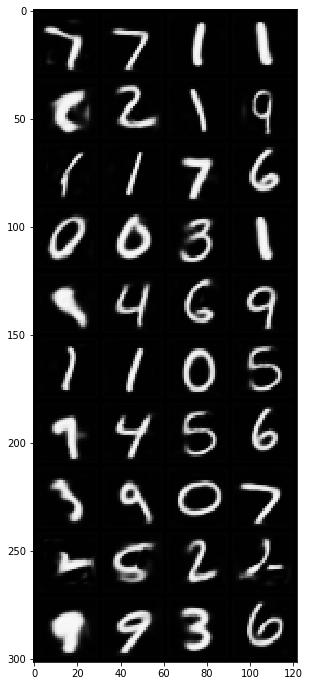

In [19]:
res = handlerRSAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=True)
fig = res['hybrids']
fname = fig_path / "hybridsHighRSAE.png"
fig.savefig(fname)

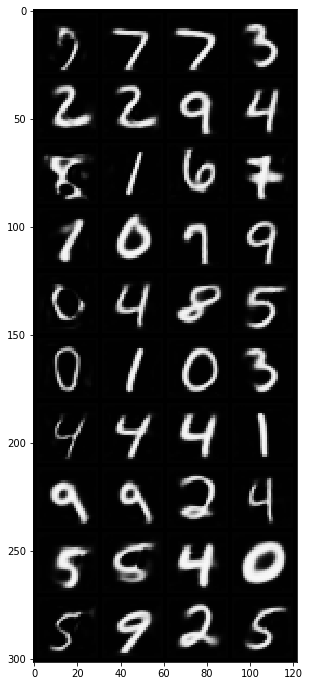

In [20]:
res = handlerRSAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=False)
fig = res['hybrids']
fname = fig_path / "hybridsLowRSAE.png"
fig.savefig(fname)

---

In [14]:
LR = handler.latent_responses(num_batches=10, num_samples=100)

Computing latent response matrix


RuntimeError: CUDA error: unspecified launch failure

---

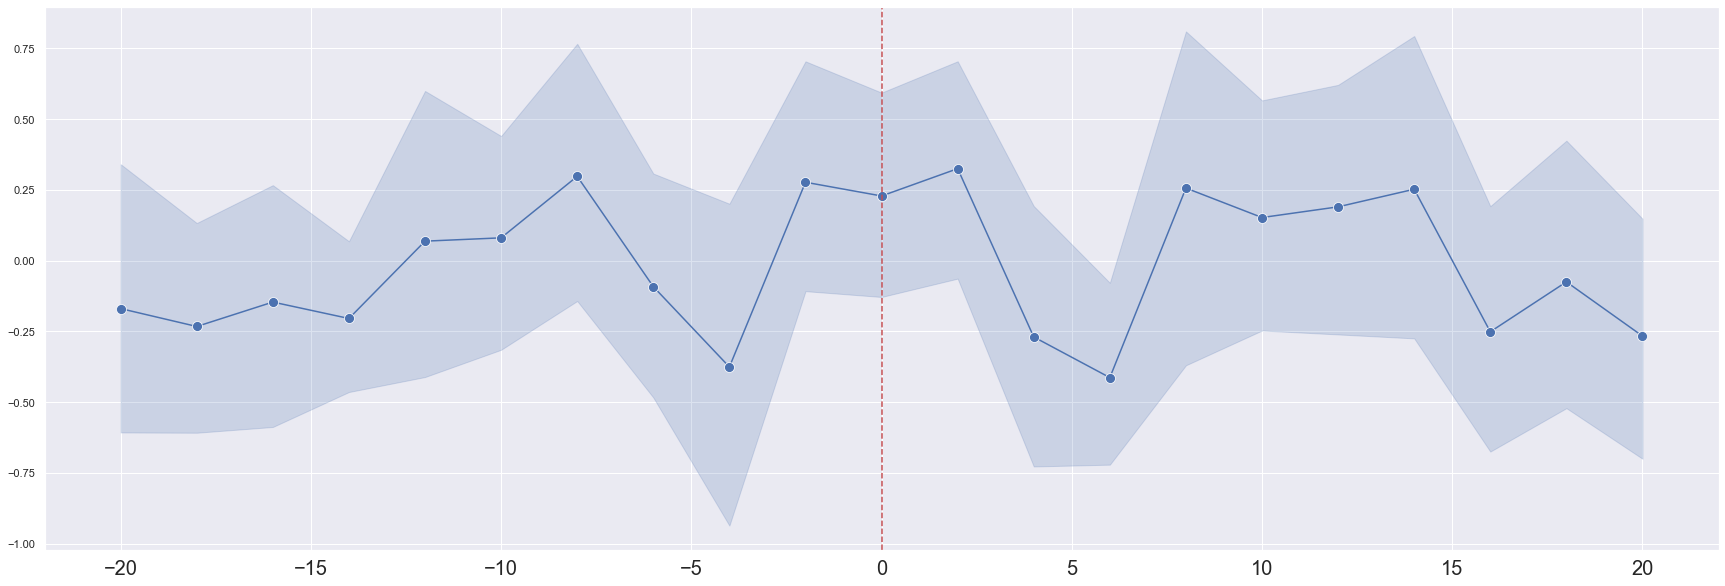

In [20]:
figure = plt.figure(figsize=(30,10))
N=21
dist = np.linspace(-20,20,21)
Nlosses = np.random.randn(N,21)
ax = sns.lineplot(np.tile(dist, N), Nlosses.reshape(-1,), marker=".", markersize=20)
ax.tick_params(axis="x", labelsize=20) 
plt.axvline(0, color='r', linestyle="--")

[(0, 30)]

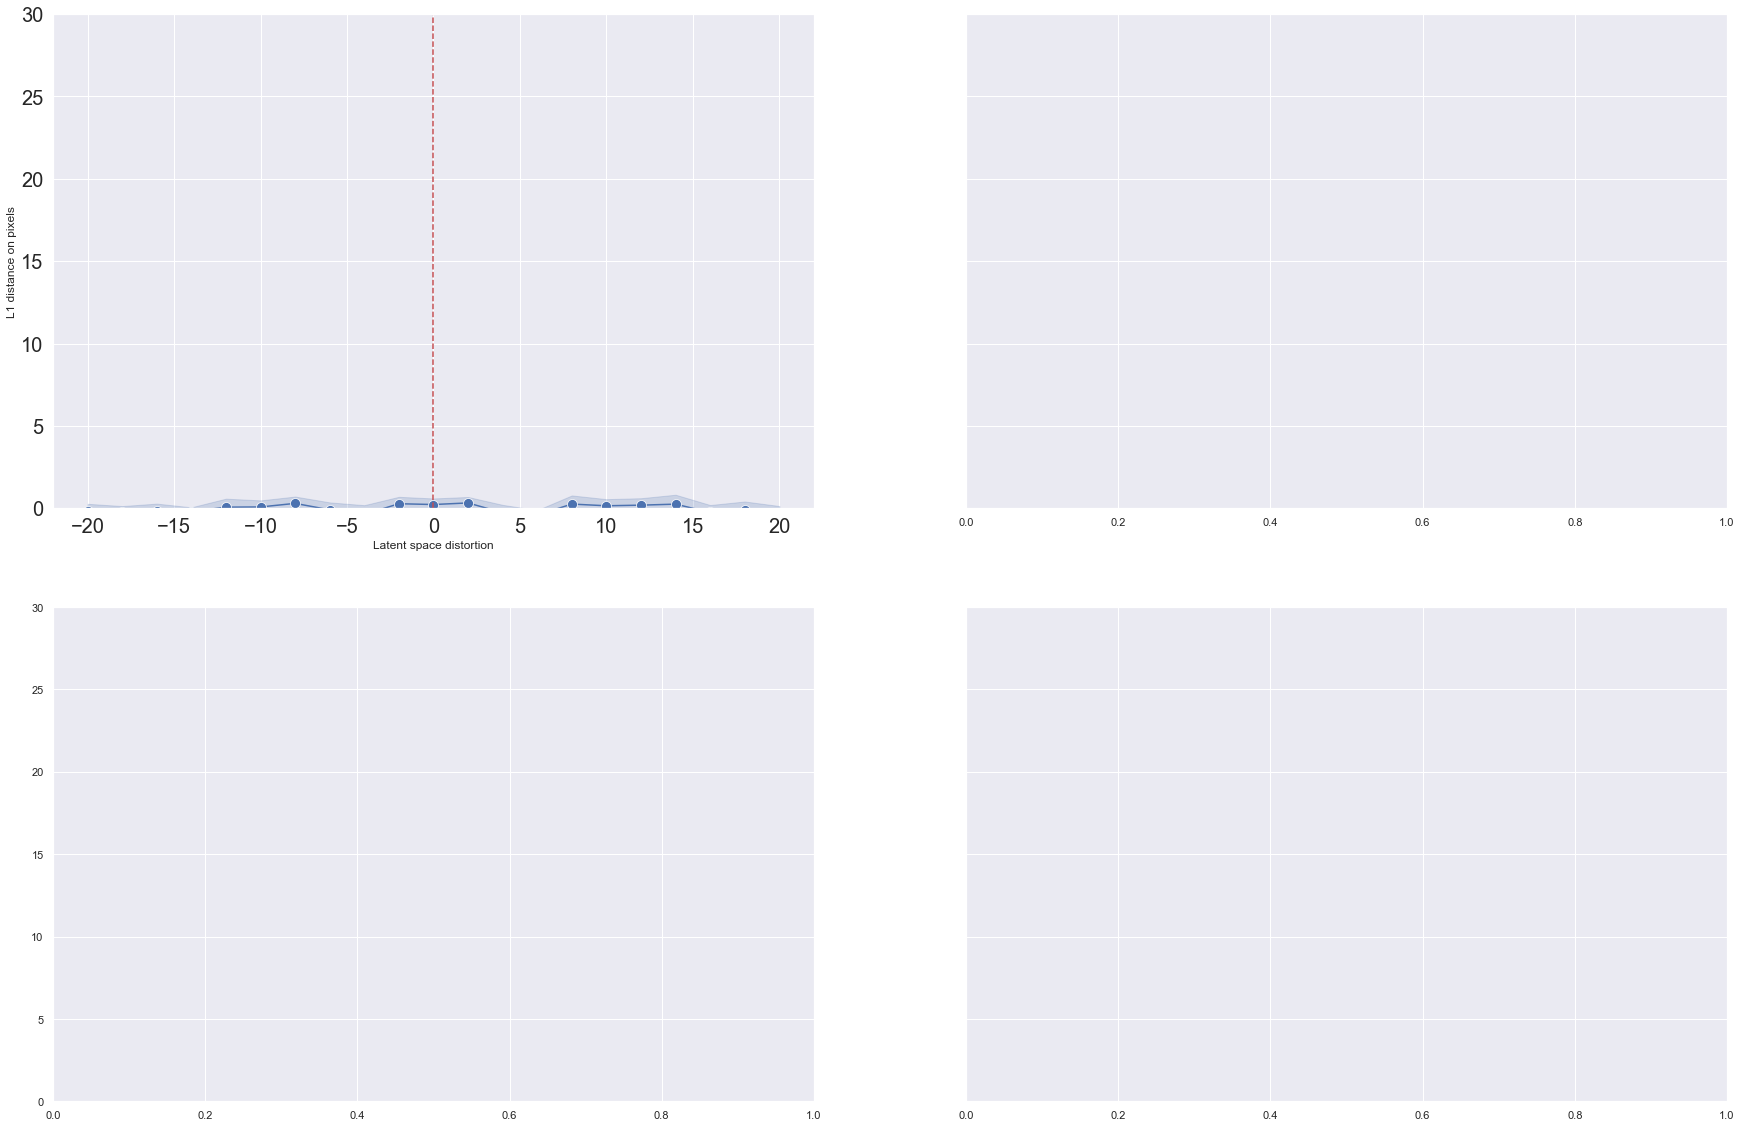

In [22]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(30,20))
sns.set(font_scale = 1)
axi=sns.lineplot(np.tile(dist, N), Nlosses.reshape(-1,), marker=".", markersize=20, ax= ax[0,0])
ax[0,0].axvline(0, color='r', linestyle="--")
axi.set(ylabel='L1 distance on pixels', xlabel='Latent space distortion')
axi.tick_params(axis="x", labelsize=20) 
axi.tick_params(axis="y", labelsize=20) 

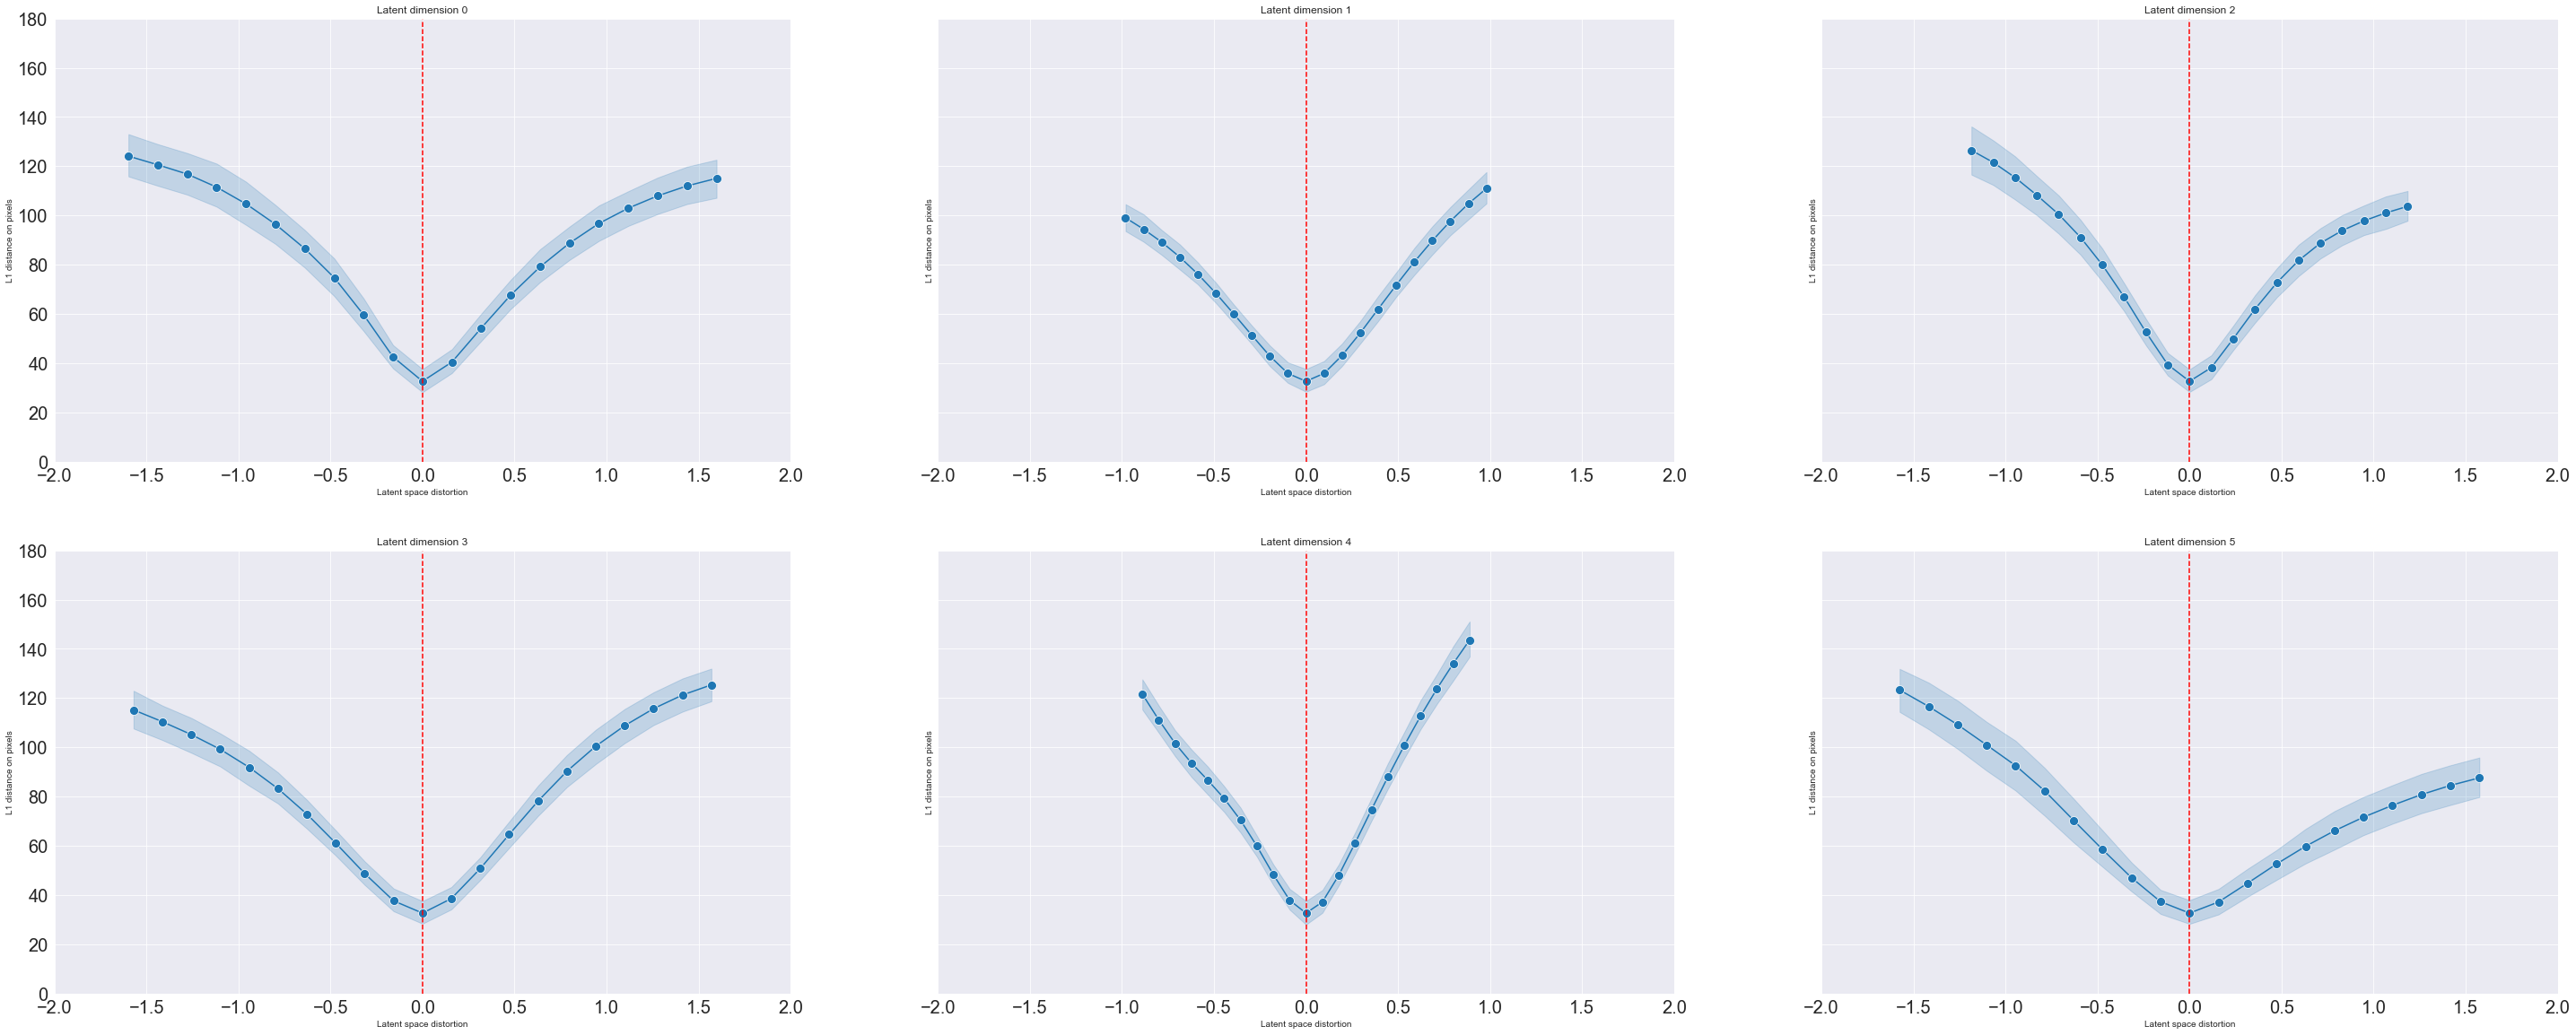

In [22]:
res = handler.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_loss2distortion=True, 
                         figsize=(50,20), nrows=2, ylim=180, xlim=2)
fig = res['distortion']
fname = fig_path / "_distortionSAE.png"
fig.savefig(fname)

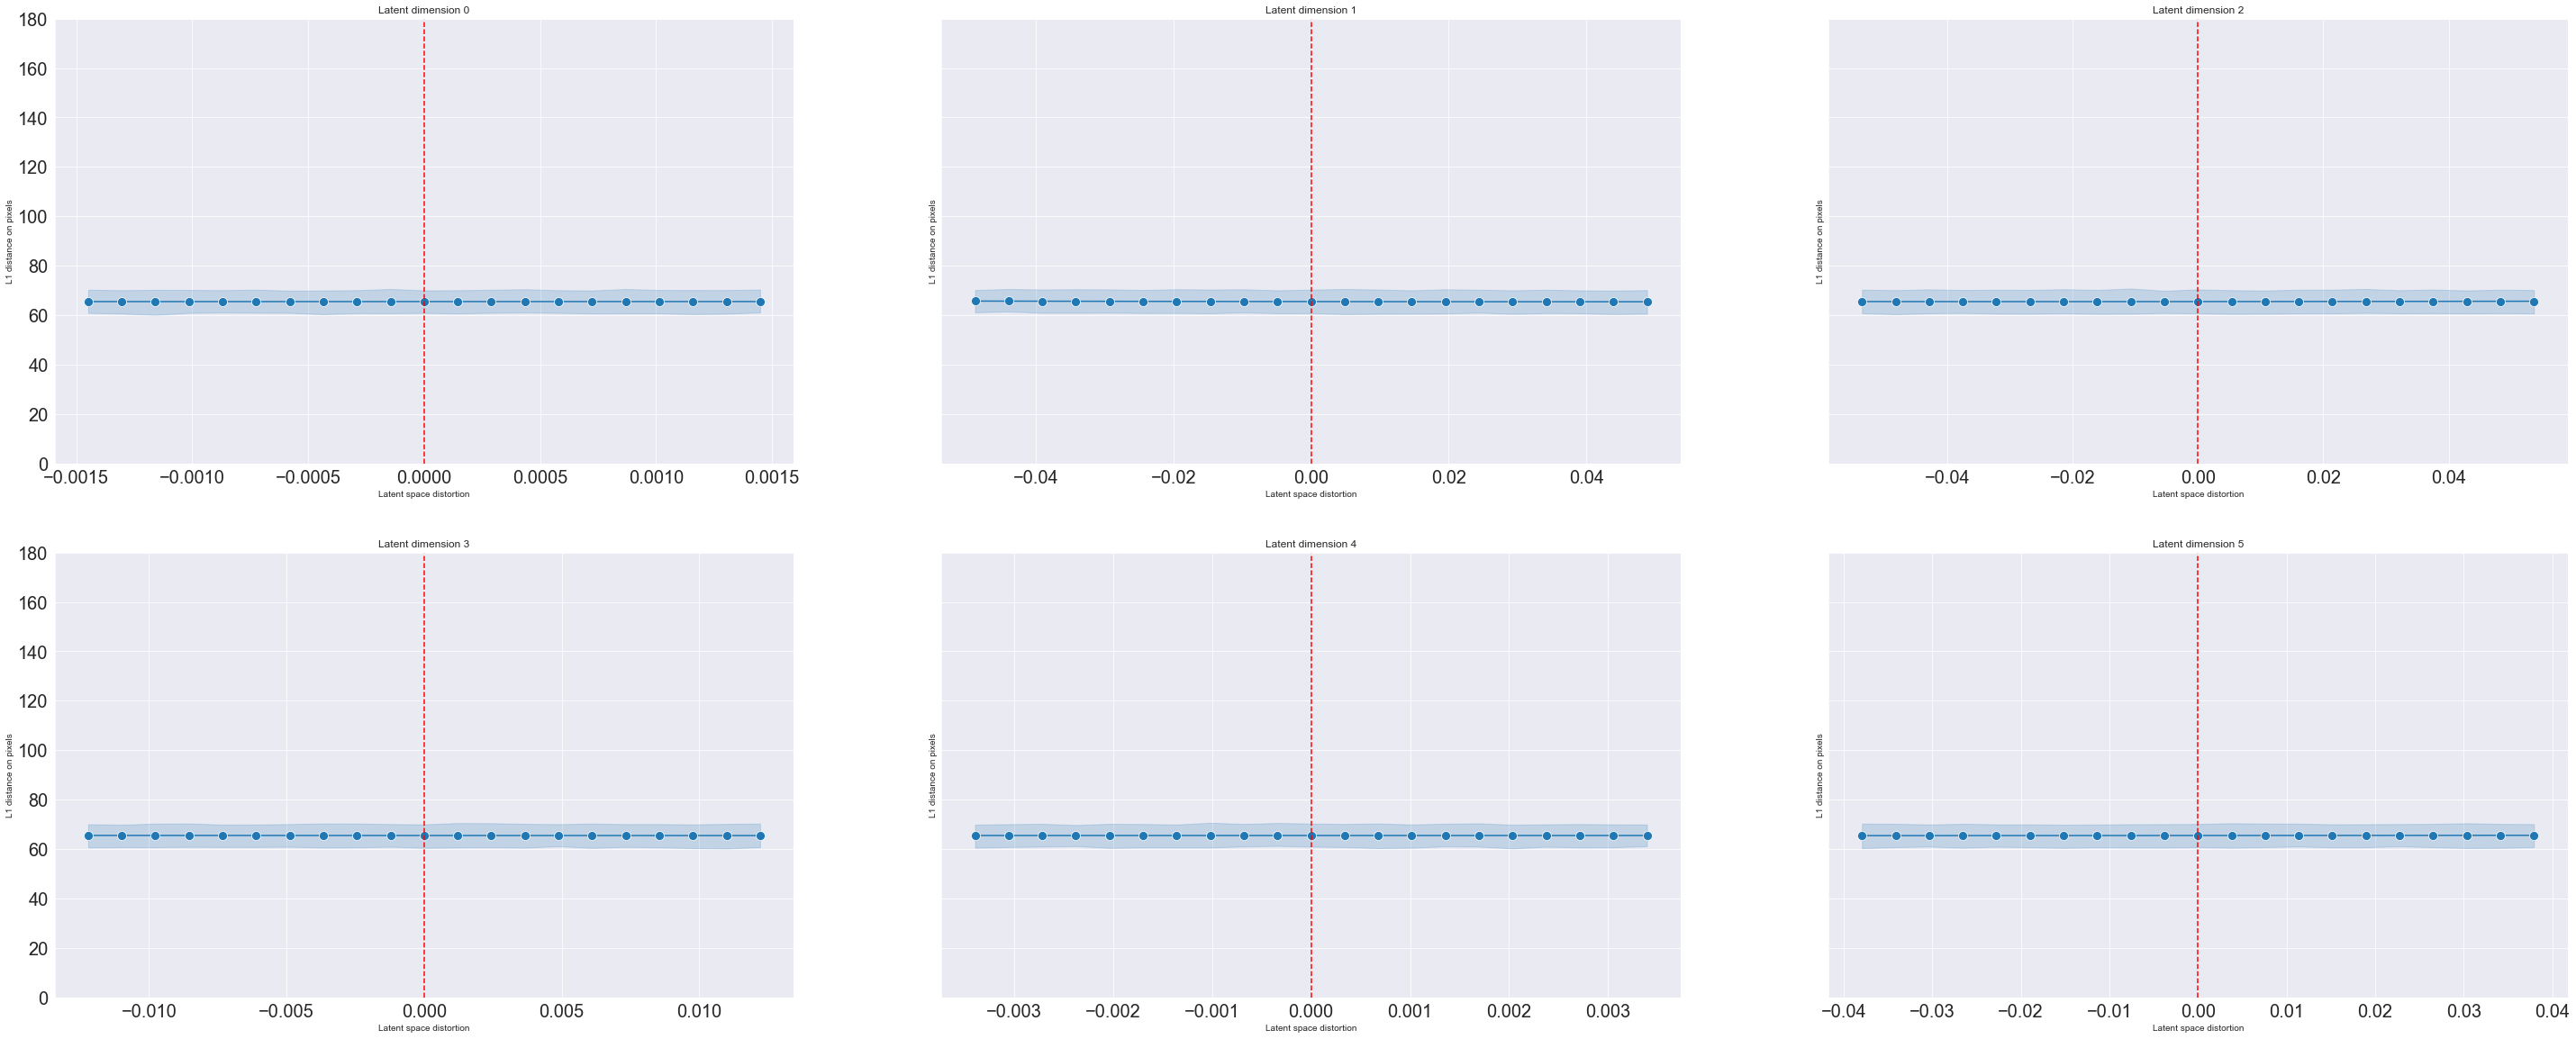

In [23]:
res = handlerESAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_loss2distortion=True, 
                             figsize=(50,20), nrows=2, ylim=180)
fig = res['distortion']
fname = fig_path / "distortionESAE.png"
fig.savefig(fname)

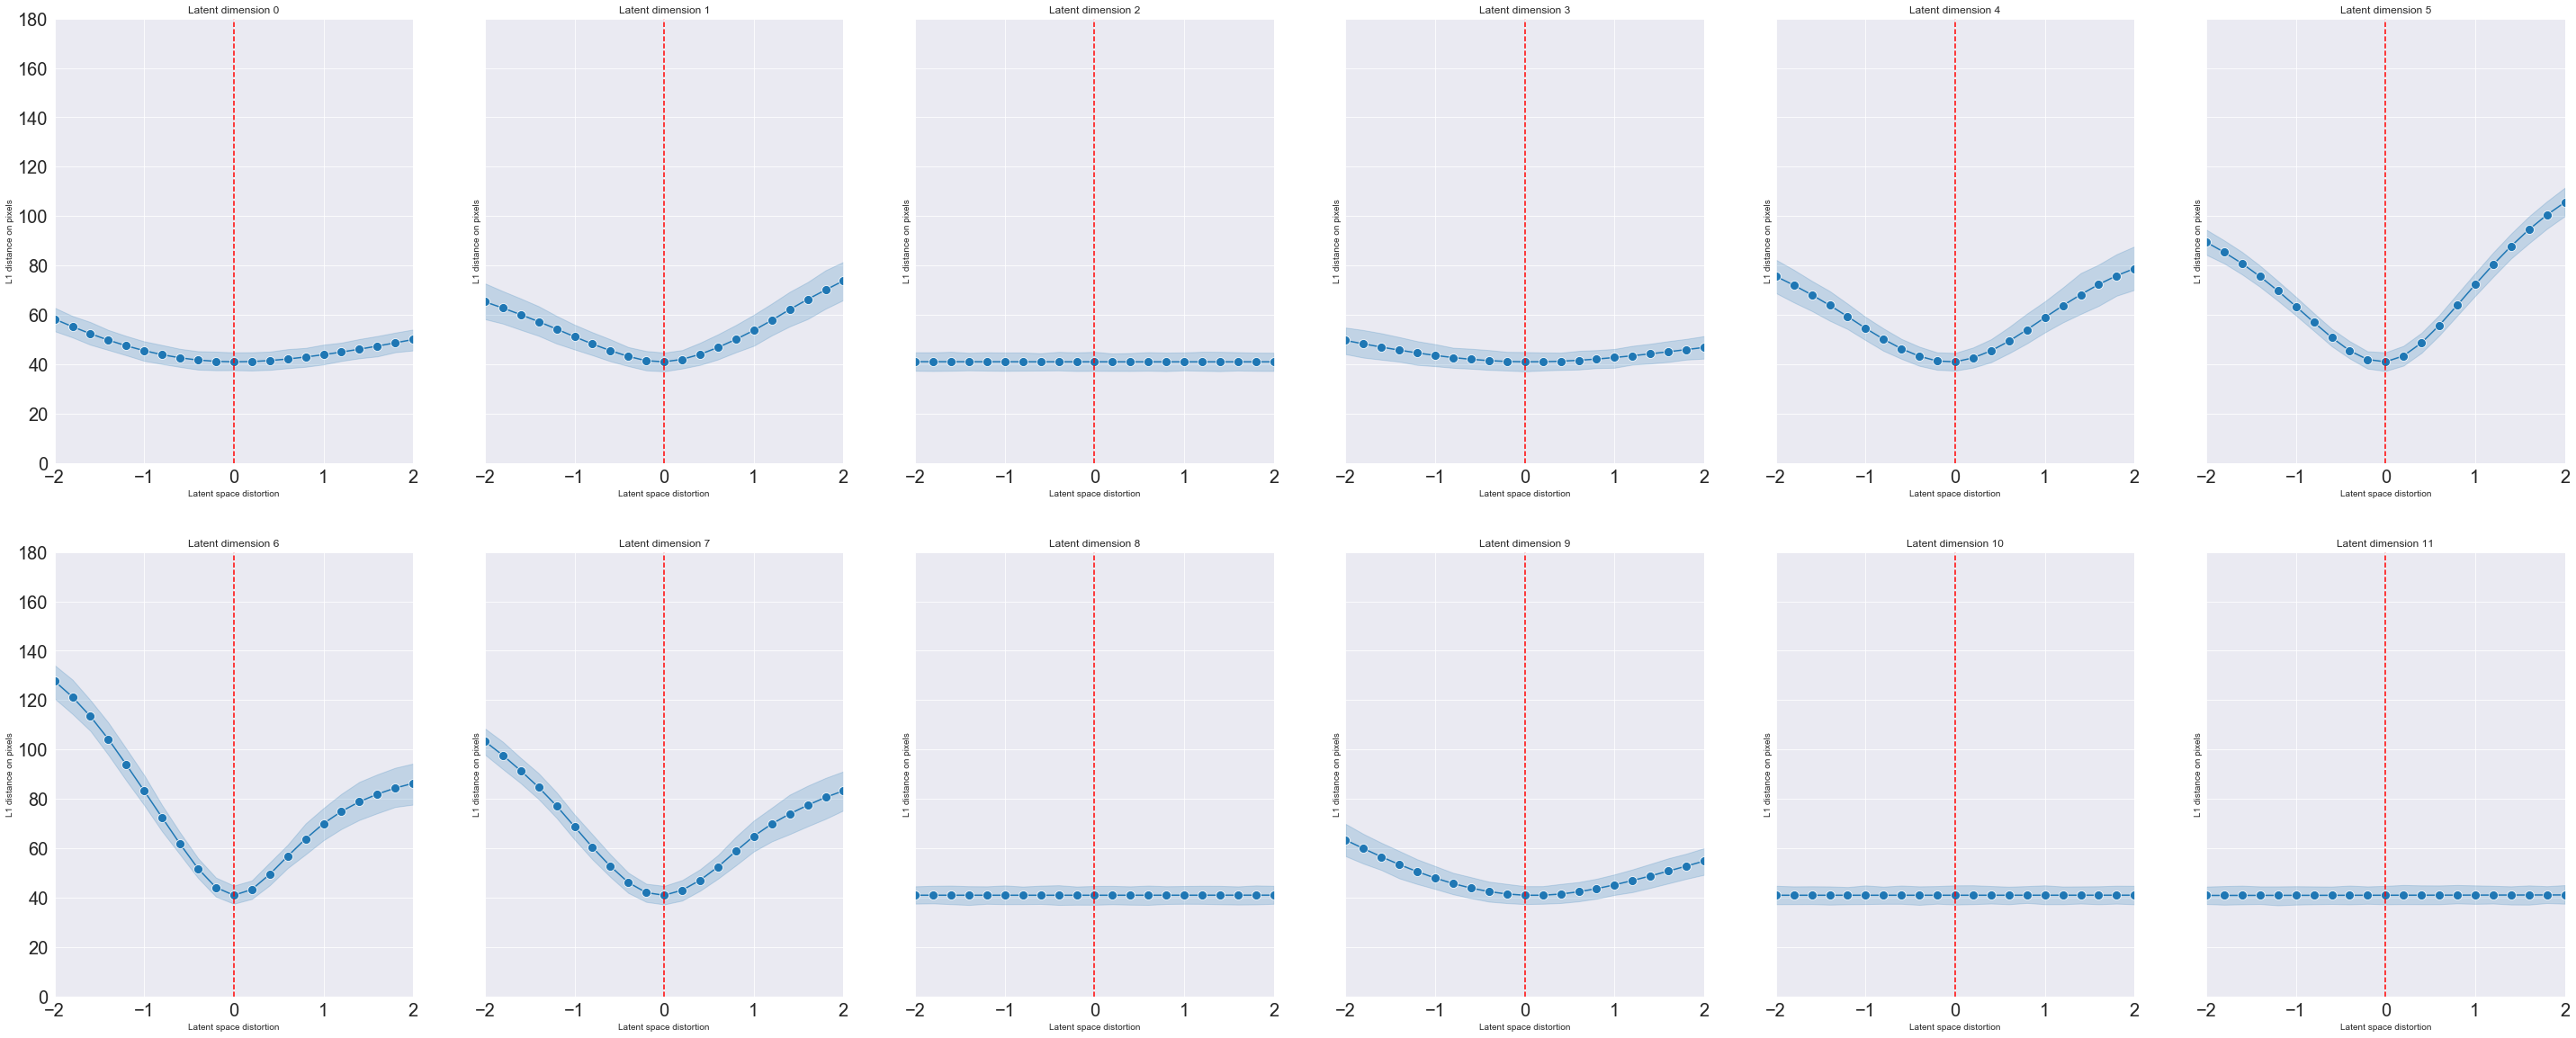

In [24]:
res = handlerVAE.plot_model(do_originals=False, do_reconstructions=False,
                            do_random_samples=False, do_traversals=False, do_loss2distortion=True, 
                            figsize=(50,20), nrows=2, font_scale=20, ylim=180, xlim=2)
fig = res['distortion']
fname = fig_path / "distortionVAE.png"
fig.savefig(fname)

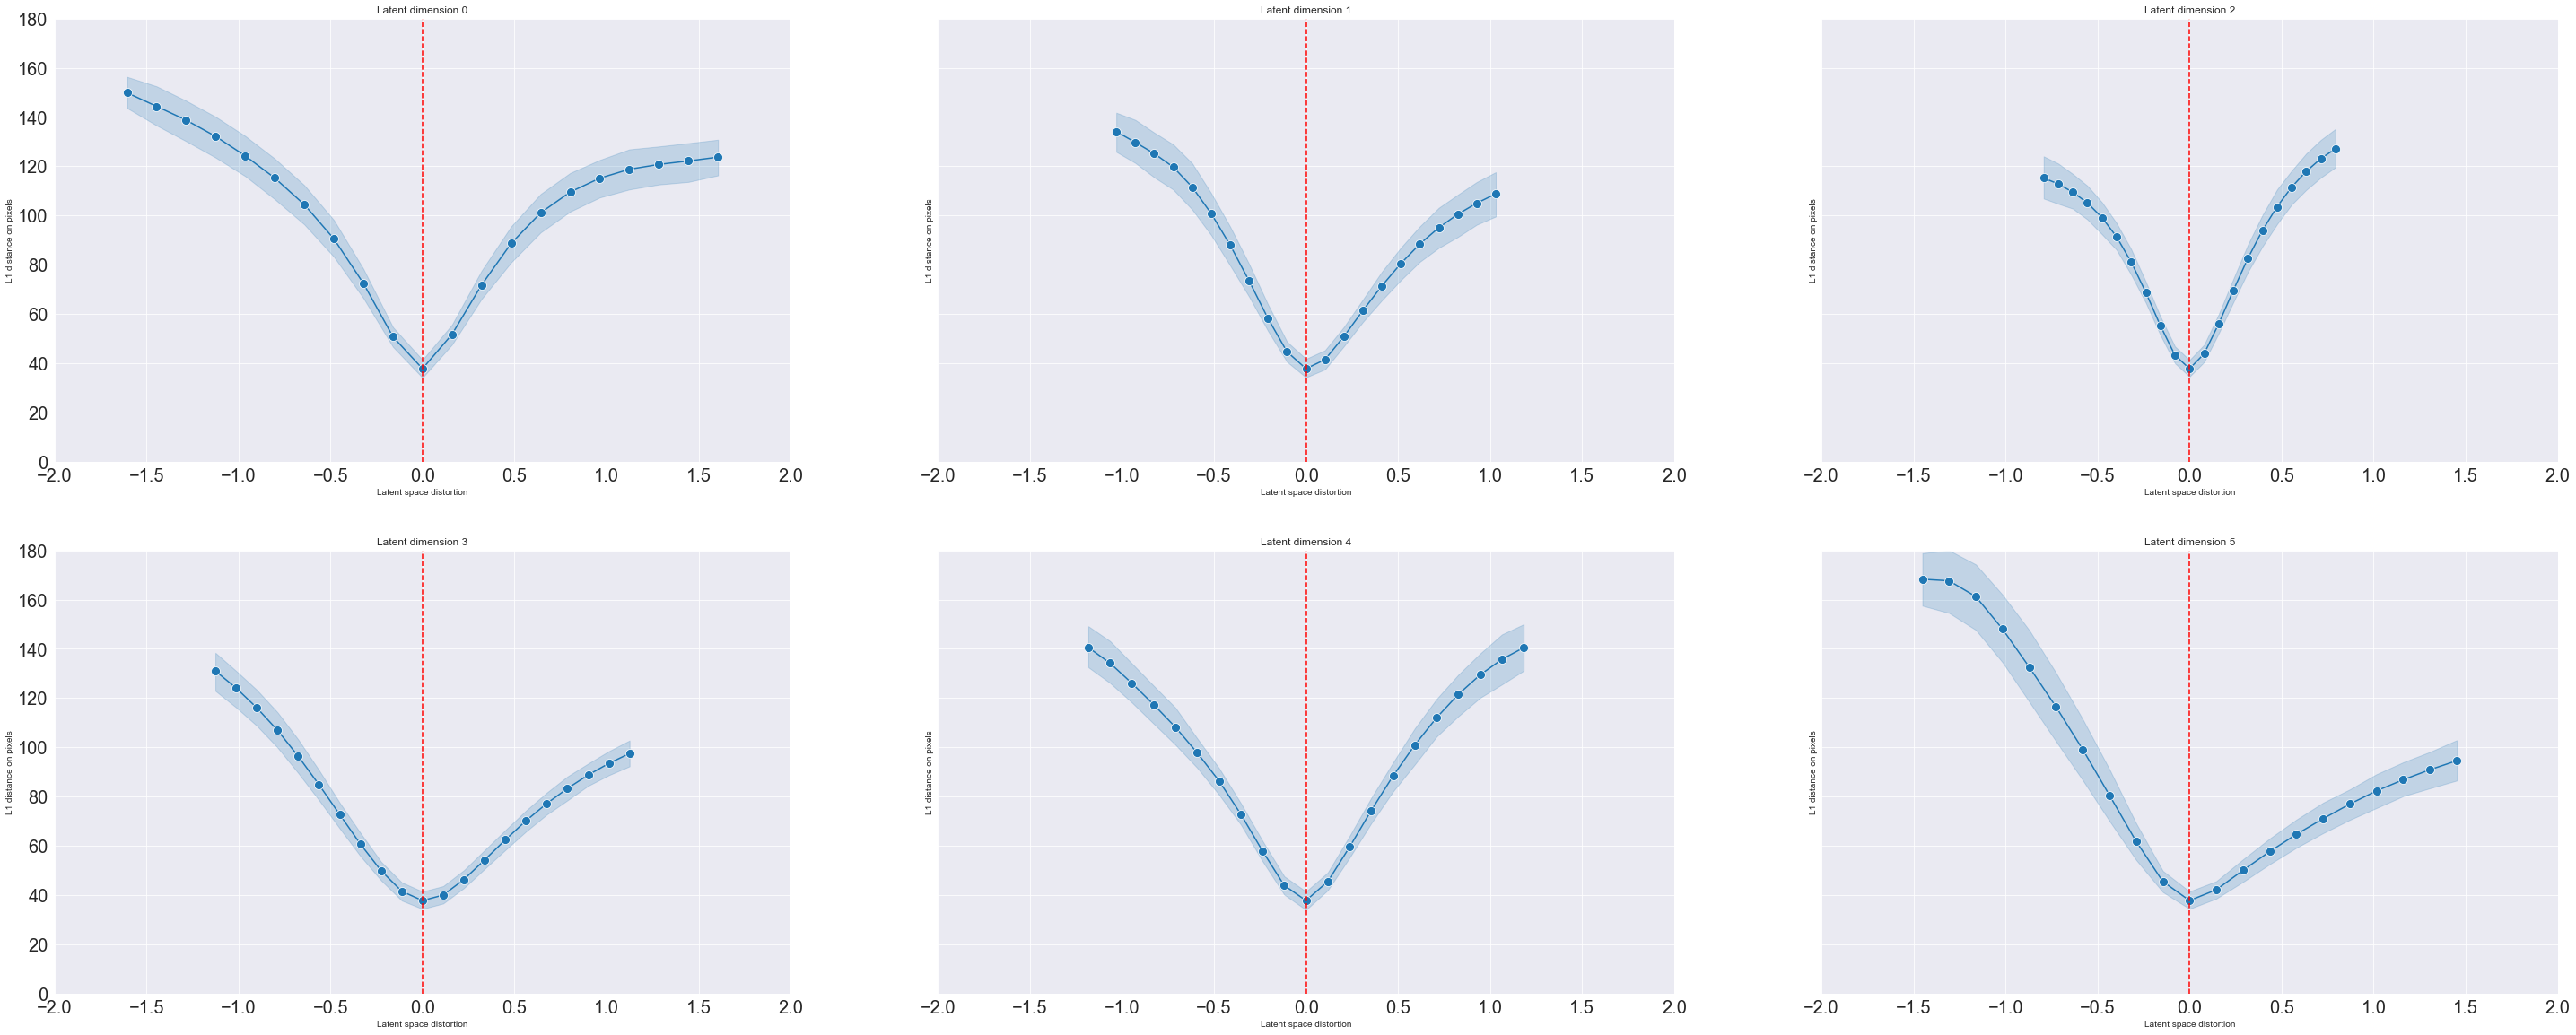

In [25]:
res = handlerRSAE.plot_model(do_originals=False, do_reconstructions=False,
                            do_random_samples=False, do_traversals=False, do_loss2distortion=True, 
                            figsize=(50,20), nrows=2, font_scale=20, ylim=180, xlim=2)
fig = res['distortion']
fname = fig_path / "distortionRSAE.png"
fig.savefig(fname)

In [11]:
vecSAE_handler = VectorModelHandler.from_config(model_name="VecSAE", model_version="standard", data="SynthVec", data_version="standard", verbose=False)

----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecSAE model hanlder loaded.


In [12]:
vecSAE_handler.load_checkpoint()

Loading latest checkpoint at logs\VecSAE\standard_SynthVec_standard\checkpoints\final.ckpt .
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          10,100
         LeakyReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 77]           7,777
         LeakyReLU-4                   [-1, 77]               0
            Linear-5                   [-1, 55]           4,290
         LeakyReLU-6                   [-1, 55]               0
            L

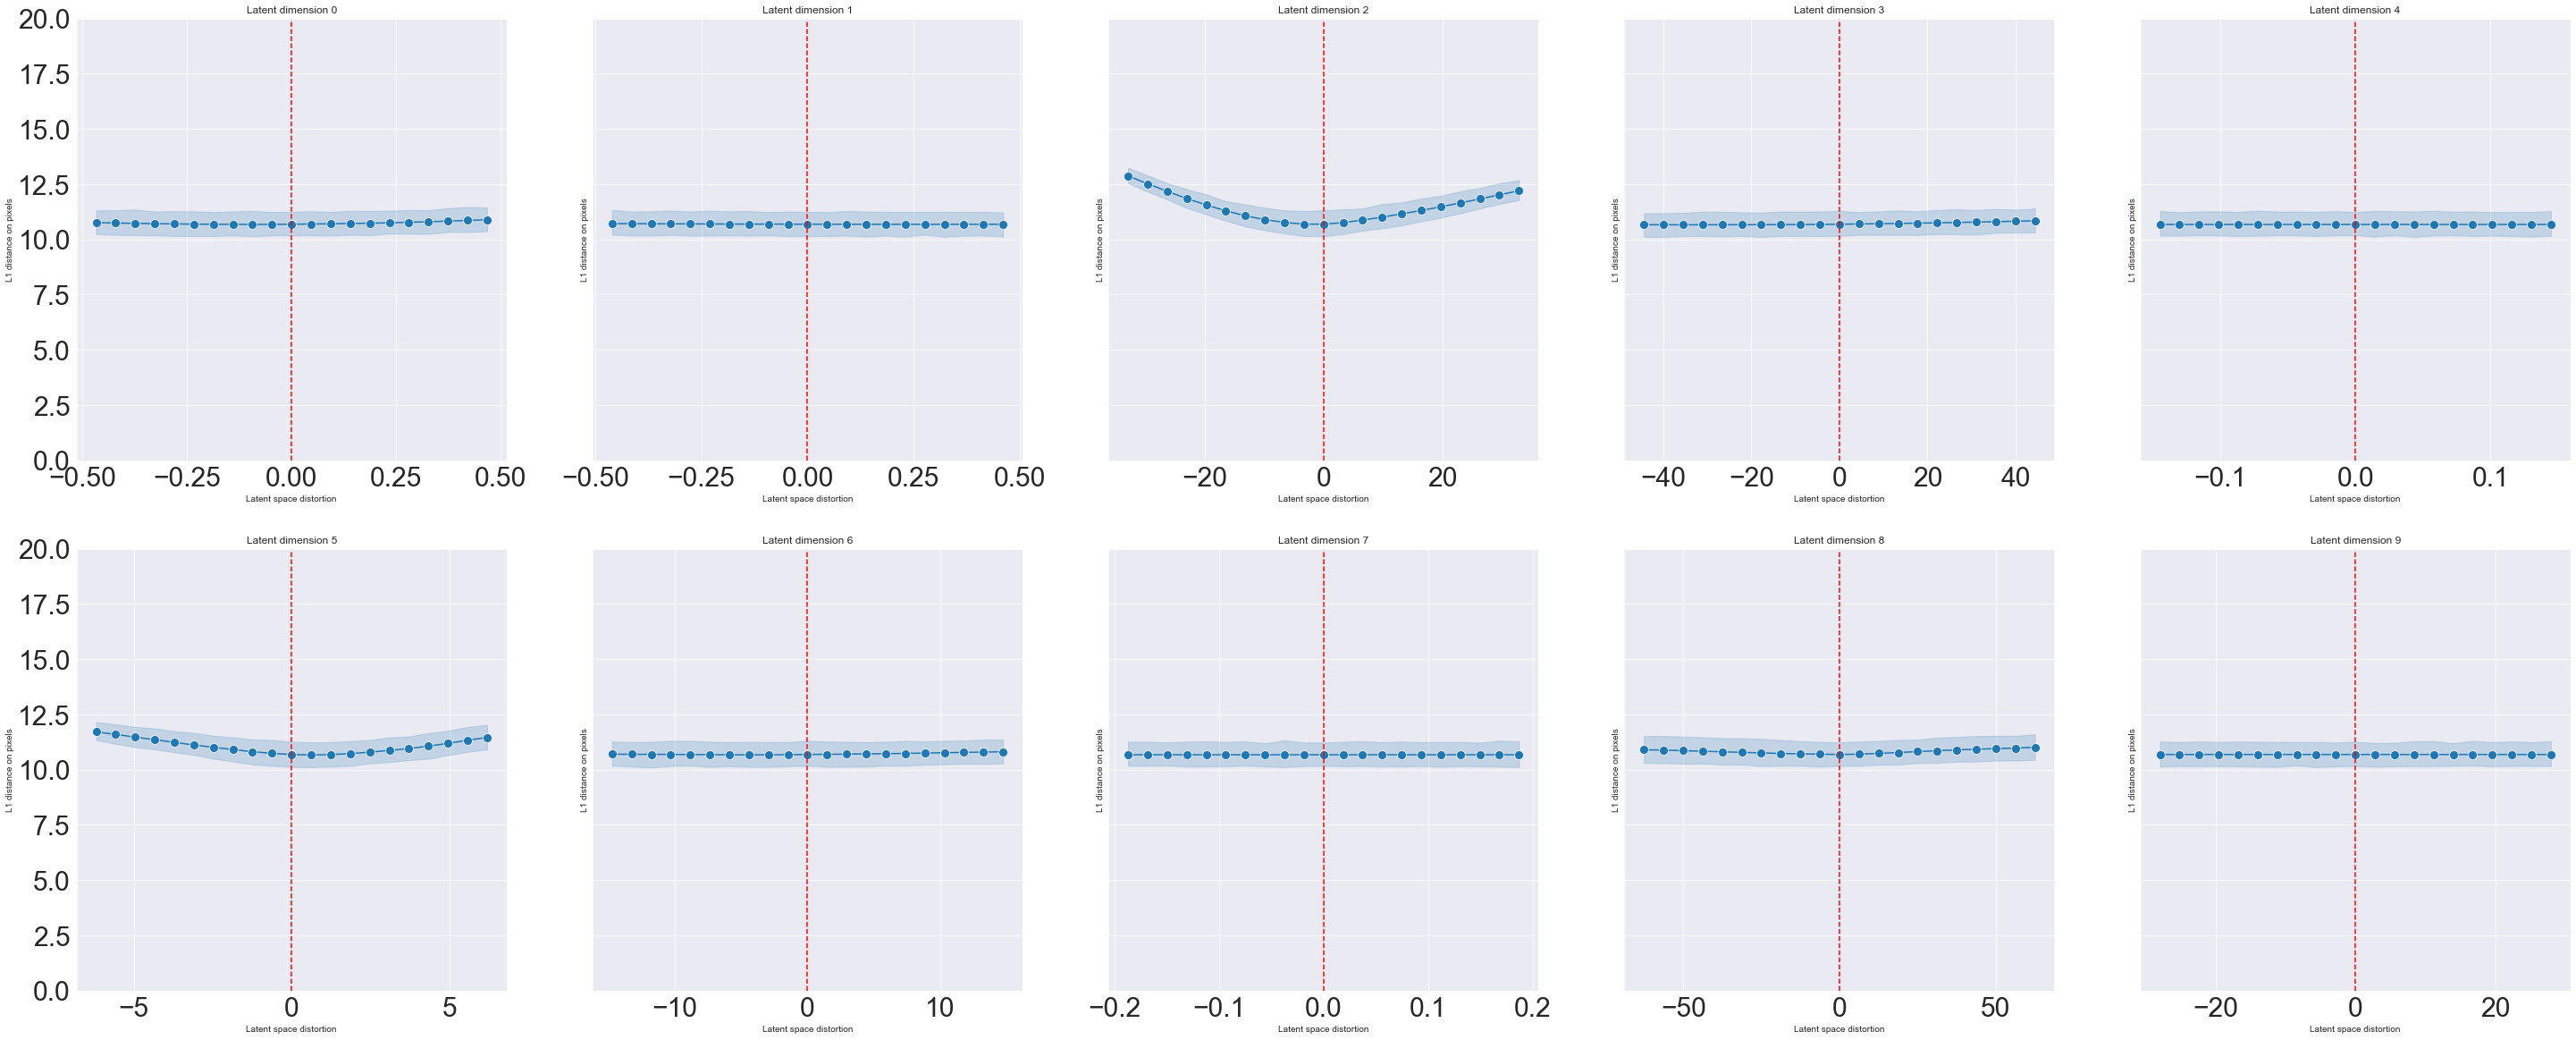

In [13]:
res = vecSAE_handler.plot_model(figsize=(50,20), nrows=2, ylim=20, font_scale=30)
fig = res['distortion']
fname = fig_path / "distortionVecSAE.png"
fig.savefig(fname)

In [8]:
vecESAE_handler = VectorModelHandler.from_config(model_name="VecESAE", model_version="standard", data="SynthVec", data_version="standard", verbose=False)

----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecESAE model hanlder loaded.


In [9]:
vecESAE_handler.load_checkpoint()

Loading latest checkpoint at logs\VecESAE\standard_SynthVec_standard\checkpoints\final.ckpt .
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          10,100
         LeakyReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 77]           7,777
         LeakyReLU-4                   [-1, 77]               0
            Linear-5                   [-1, 55]           4,290
         LeakyReLU-6                   [-1, 55]               0
            

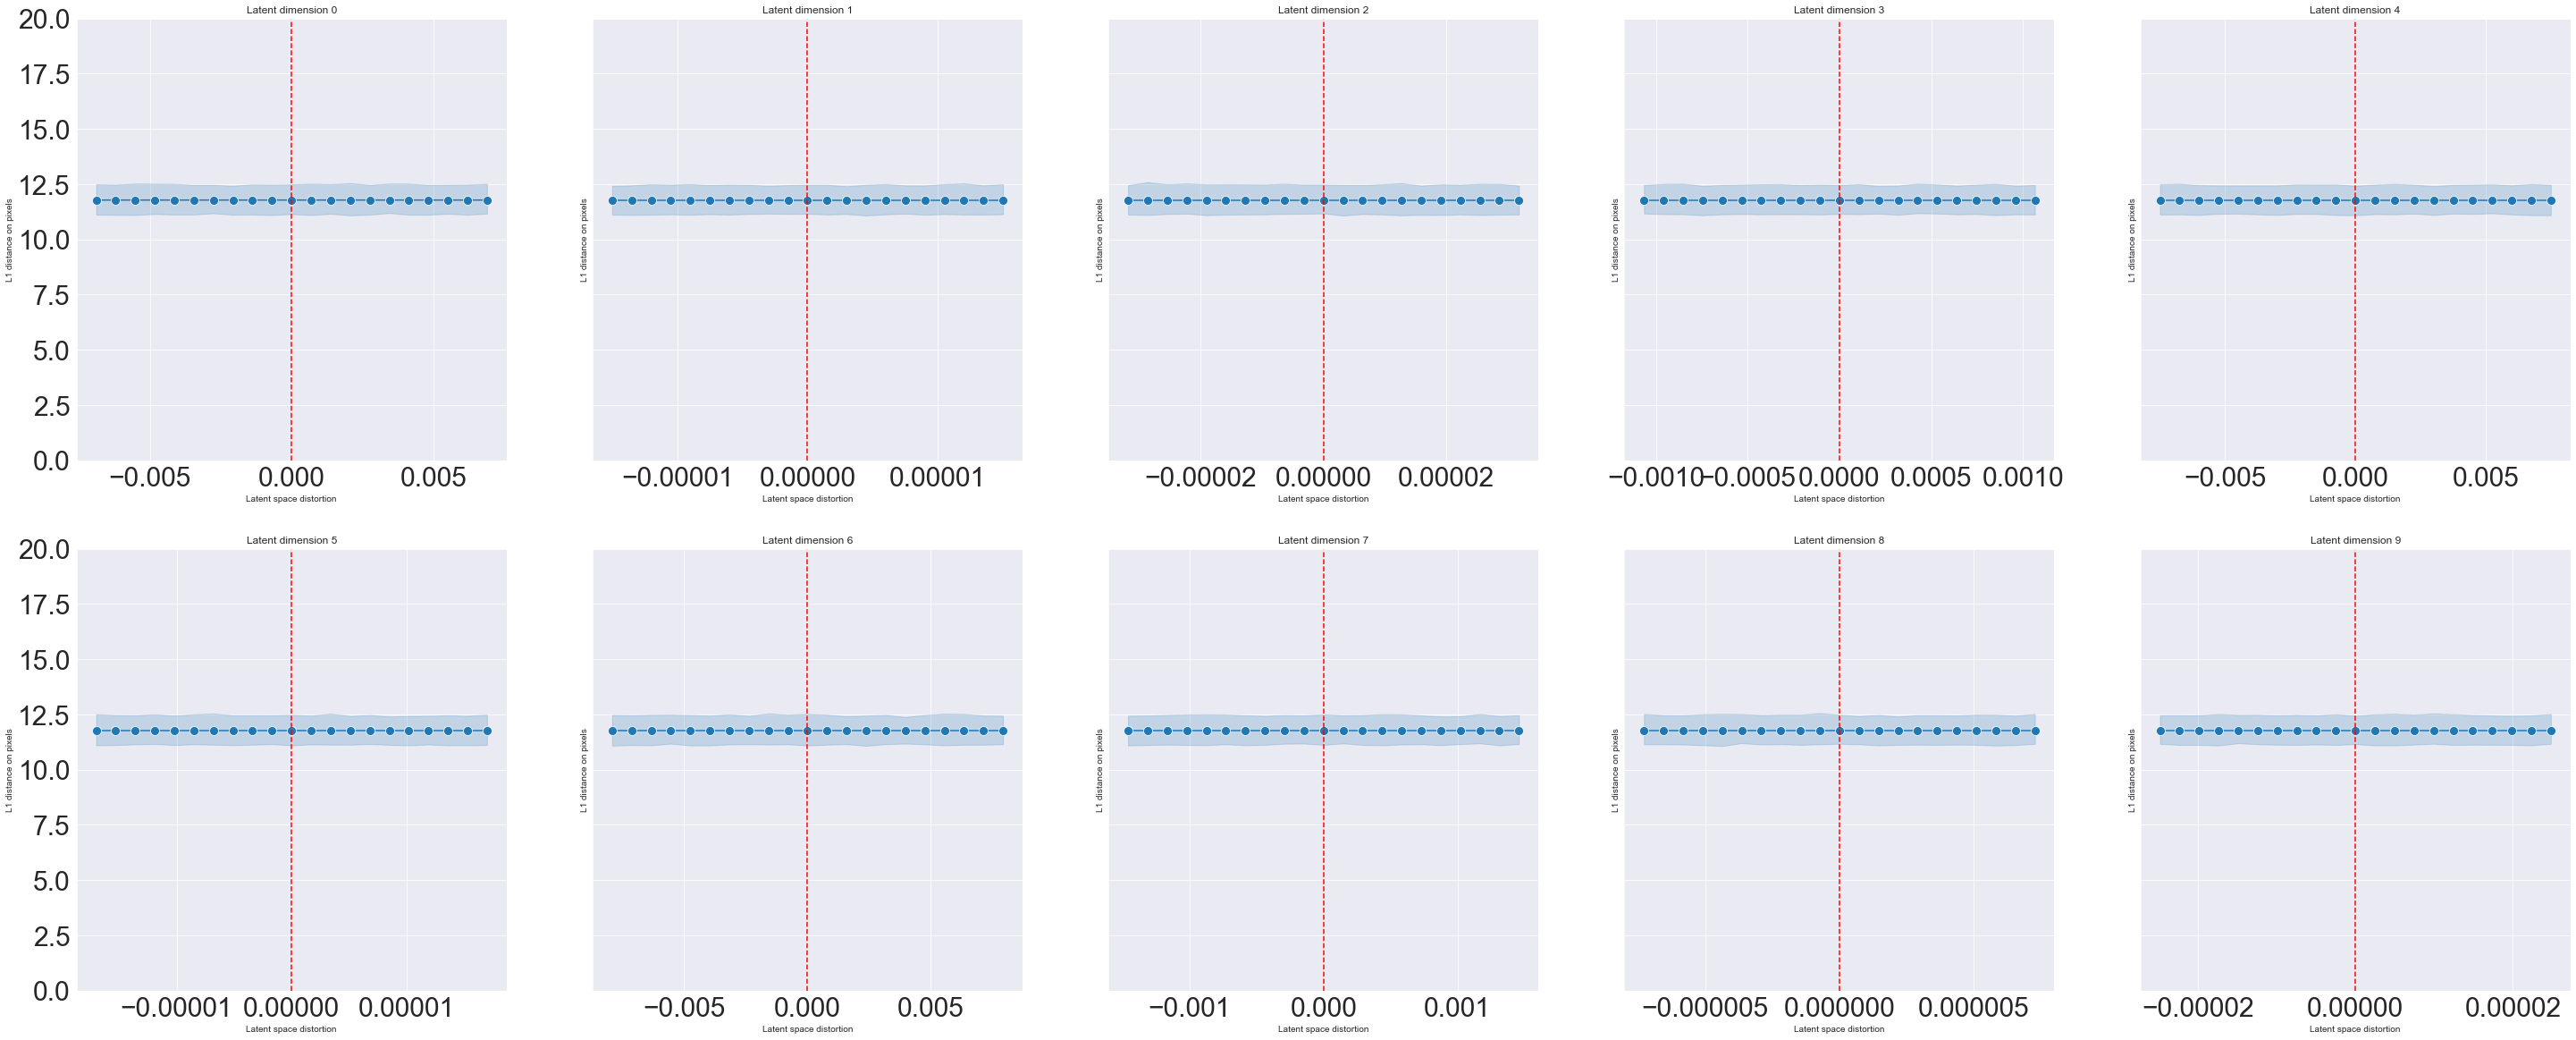

In [15]:
res = vecESAE_handler.plot_model(figsize=(50,20), nrows=2, ylim=20, font_scale=30)
fig = res['distortion']
fname = fig_path / "distortionVecESAE.png"
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)

In [17]:
vecVAE_handler = VectorModelHandler.from_config(model_name="VecVAE", model_version="standard", data="SynthVec", data_version="standard", verbose=False)

----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecVAE model hanlder loaded.


In [22]:
vecVAE_handler.load_checkpoint()

Loading latest checkpoint at logs\VecVAE\standard_SynthVec_standard\checkpoints\epoch=24-step=13627.ckpt .
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          10,100
         LeakyReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 77]           7,777
         LeakyReLU-4                   [-1, 77]               0
            Linear-5                   [-1, 55]           4,290
         LeakyReLU-6                   [-1, 55]               0

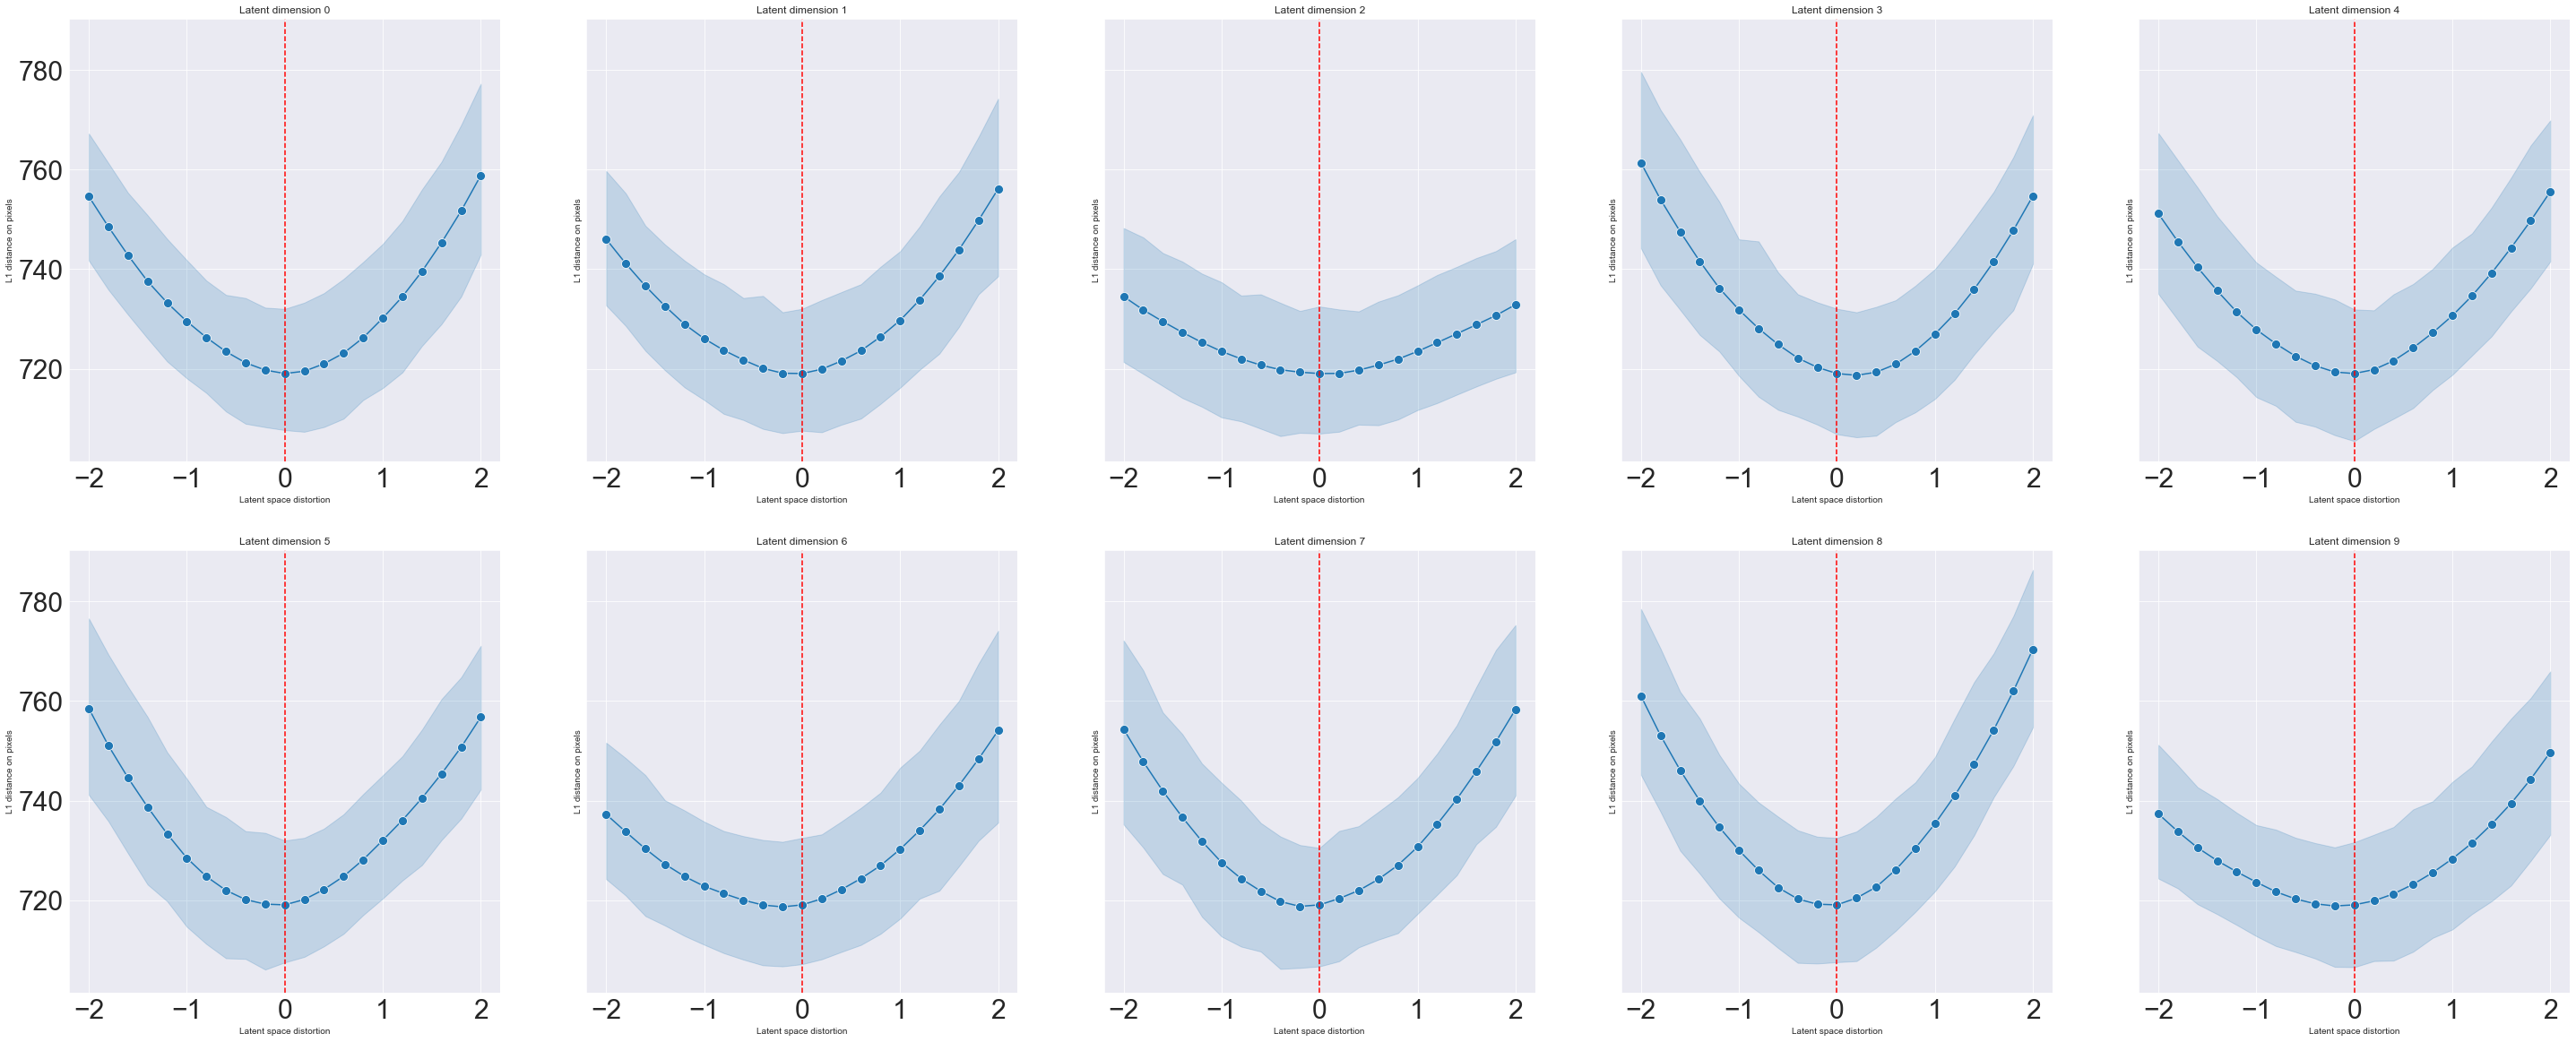

In [23]:
res = vecVAE_handler.plot_model(figsize=(50,20), nrows=2, font_scale=30)
fig = res['distortion']
fname = fig_path / "distortionVecVAE.png"
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)

---

In [20]:
model_names = ["SAE","ESAE","VAE", "RSAE"]
scores_df = pd.DataFrame()
scores_df["model_name"] = model_names
all_scores = []

In [21]:
scores = handler.score_model(FID=False, disentanglement=True, orthogonality=True,save_scores=True, full=False)

Preparing the model for scoring orthogonality ...
Scoring orthogonality
RBF scoring
IMQ scoring
CAT scoring
dCov scoring


c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\dcor\_fast_dcov_avl.py:317: UserWarning: Falling back to uncompiled AVL fast distance covariance because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, A), array(float32, 1d, A), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(f"Falling back to uncompiled AVL fast distance "


Scoring model disentanglement.
DCI scoring


c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2625: RuntimeWarning: invalid value encountered in true_divide
  S /= log(base)
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2625: RuntimeWarning: divide by zero encountered in log
  S /= log(base)
C:\Users\Giulia\Study\projects\research\SAE\metrics\DCI.py:172: RuntimeWarning: invalid value encountered in true_divide
  code_importance = importance_matrix.sum(axis=1) / importance_matrix.sum()


IRS scoring
MIG scoring
Modularity explicitness scoring


C:\Users\Giulia\Study\projects\research\SAE\metrics\ModExp.py:123: RuntimeWarning: invalid value encountered in true_divide
  delta = numerator / denominator
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


SAP scoring
Time elapsed for scoring 83


In [22]:
all_scores.append(scores)

In [23]:
#scores = handlerESAE.score_model(FID=False, disentanglement=True, orthogonality=True, save_scores=True, full=False)
scores = handlerESAE.load_scores()
all_scores.append(scores)

In [24]:
#scores = handlerVAE.score_model(FID=False, disentanglement=True, orthogonality=True, save_scores=True, full=False)
scores = handlerVAE.load_scores()
all_scores.append(scores)

In [25]:
scores = handlerRSAE.load_scores()
all_scores.append(scores)

In [26]:
for i,score_set in enumerate(all_scores): 
    for k,v in score_set.items():
        scores_df.loc[i,k] = v

In [27]:
scores_df

,model_name,RBF,IMQ,CAT,dCOV,DCI,IRS,MIG,ModExp,SAP
0,SAE,0.002699,0.023504,-39.176571,0.224136,NaN,0.620863,0.054272,NaN,0.004
1,ESAE,0.004271,0.028948,-41.469337,0.292190,NaN,0.492522,0.019467,NaN,0.024
2,VAE,0.001465,0.010816,-147.206253,0.140675,NaN,0.410131,0.013262,NaN,0.012
3,RSAE,0.002829,0.024132,-32.255348,0.191865,NaN,0.633627,0.030117,NaN,0.012


## Collecting scores for synthetic vector dataset experiments

In [28]:
#load all scores and save them in lists 
#extract relevan numbers from the lists and form a df
# plot df with seaborn
data_versions = ["standard","discrete","continuous","big"]
model_names = ["VecESAE","VecSAE","VecVAE"]

In [40]:
handlers=[]
for data_v in data_versions:
    for model_n in model_names: 
        handler = (VectorModelHandler(model_name=model_n, model_version="standard", 
                                           data="SynthVec", data_version=data_v, verbose=False))
        handlers.append(handler)

Loading VecESAE
--------------------
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecESAE model loaded.
Loading VecSAE
--------------------
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecSAE model loaded.
Loading VecVAE
--------------------
----------Opening SynthVec dataset version standard / train----------
Files already th

In [41]:
scores_df = pd.DataFrame()

In [42]:
scores_df["model_name"] = model_names*len(data_versions)
scores_df["data_version"] = [item for data_v in data_versions for item in [data_v]*len(model_names)]

In [43]:
scores = [handler.load_scores(name="scoring") for handler in handlers]

# - to go 
#scores = [handlers[3].load_scores()]
#scores[0]["extra_disentanglement"]=None

In [44]:
scores[0]

{'RBF': 0.015189409255981445,
 'IMQ': 0.04211711883544922,
 'CAT': -0.1615293025970459,
 'dCOV': 0.0004448918977173883,
 'DCI': 0.022975431934453228,
 'IRS': 0.6610408347408944,
 'MIG': 0.027064272688382594,
 'ModExp': 0.3066816420810107,
 'SAP': 0.0007999999999999993}

In [45]:
for i,score_set in enumerate(scores): 
    for k,v in score_set.items():
        scores_df.loc[i,k] = v

In [ ]:
# random fill - useful to test visualisations
#for k,v in scores[0].items():
#    scores_df.loc[:,k] = np.random.randn(12)**2
#scores_df = scores_df.drop("extra_disentanglement", axis=1)

In [46]:
scores_df

,model_name,data_version,RBF,IMQ,CAT,dCOV,DCI,IRS,MIG,ModExp,SAP
0,VecESAE,standard,0.015189,0.042117,-0.161529,0.000445,0.022975,0.661041,0.027064,0.306682,0.000800
1,VecSAE,standard,0.026888,0.069378,-802.112671,5.240126,0.005647,0.674220,0.005635,0.430792,0.011800
2,VecVAE,standard,0.001399,0.010498,-127.531487,0.141176,0.000990,0.350142,0.002403,0.290196,0.007000
3,VecESAE,discrete,0.022906,0.057015,-0.446848,0.001741,0.017003,0.562547,0.017709,0.600752,0.003200
4,VecSAE,discrete,0.024454,0.033591,-1294.276245,4.202439,0.015070,0.625581,0.028266,0.617612,0.026800
5,VecVAE,discrete,0.001554,0.010958,-131.270096,0.142695,0.001734,0.370357,0.002599,0.653227,0.007800
6,VecESAE,continuous,0.009773,0.025878,-1.281475,0.006464,0.038372,0.831236,0.008693,0.585250,0.010667
7,VecSAE,continuous,0.003799,0.012843,-4008.612305,10.538882,0.005245,0.893096,0.001633,0.691180,0.016667
8,VecVAE,continuous,0.001347,0.010366,-129.345398,0.141924,0.005222,0.389475,0.005156,0.368557,0.007333
9,VecESAE,big,0.015315,0.041043,-20.298193,0.069307,0.009026,0.779077,0.009870,0.419960,0.011800


## Visualisations of model scores

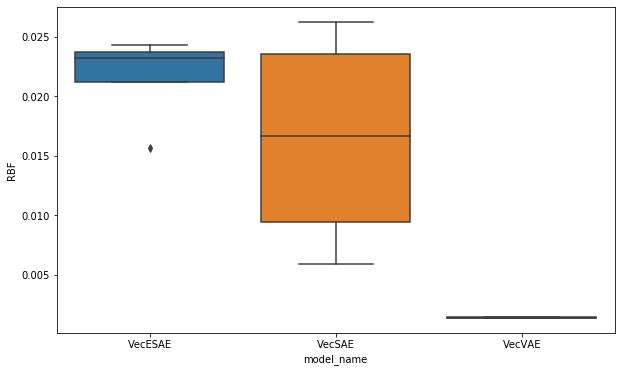

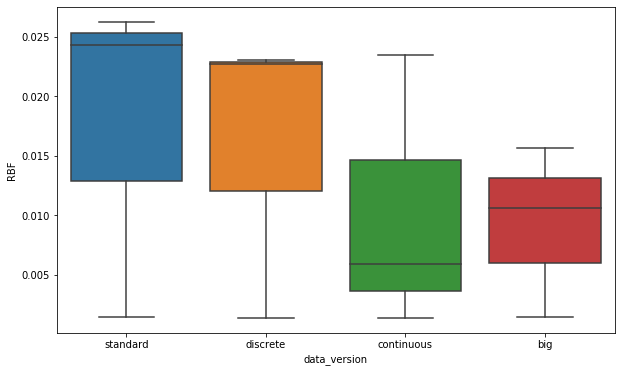

In [18]:
# finally visualising 
plt.figure(figsize=(10,6))
sns.boxplot(x='model_name',y='RBF',data=scores_df)
# finally visualising 
plt.figure(figsize=(10,6))
sns.boxplot(x='data_version',y='RBF',data=scores_df)


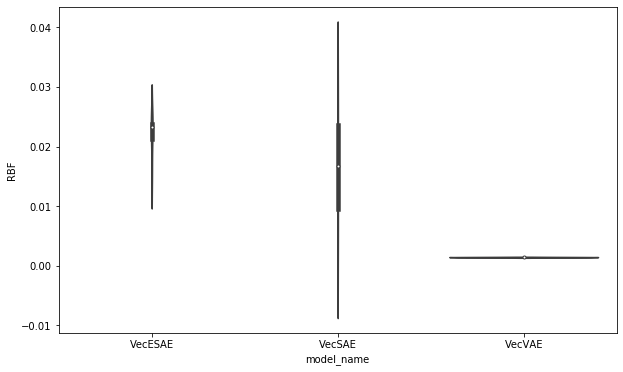

In [19]:
plt.figure(figsize=(10,6))
sns.violinplot(x='model_name',y='RBF',data=scores_df, split=True)
#sns.swarmplot(x='model_name',y='RBF',data=scores_df, split=True, color="white")

In [20]:
scores_df.columns[2:5]

Index(['RBF', 'IMQ', 'CAT'], dtype='object')

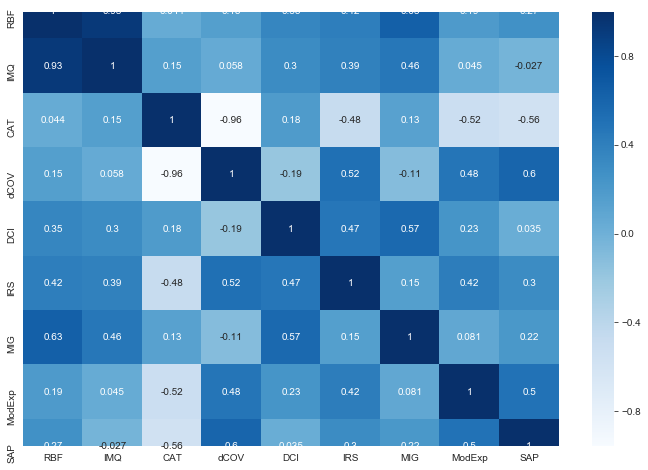

In [49]:
plt.figure(figsize=(12,8))

scores_corr = scores_df.corr()
sns.heatmap(scores_corr, annot=True, cmap='Blues')


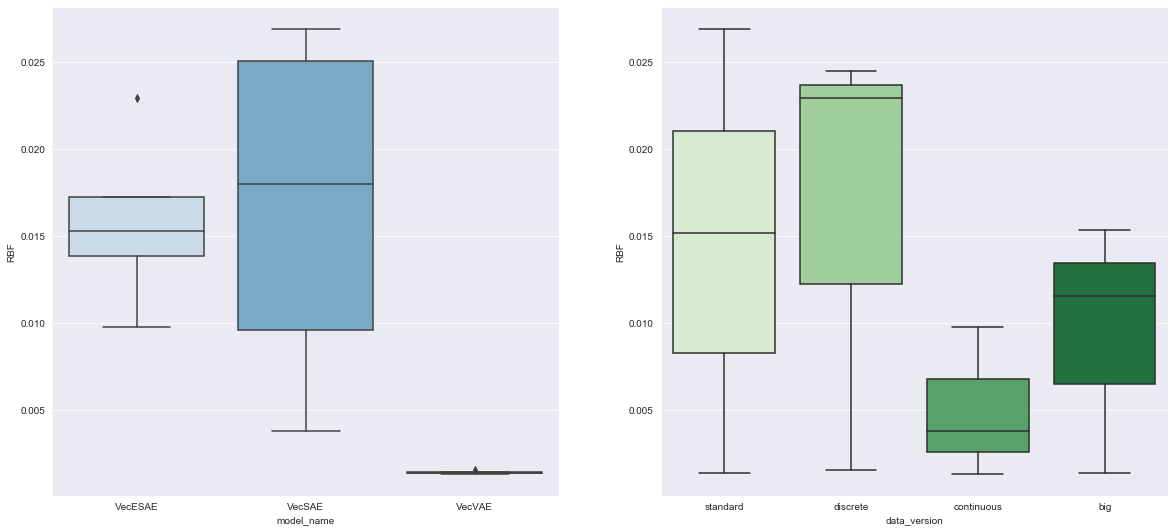

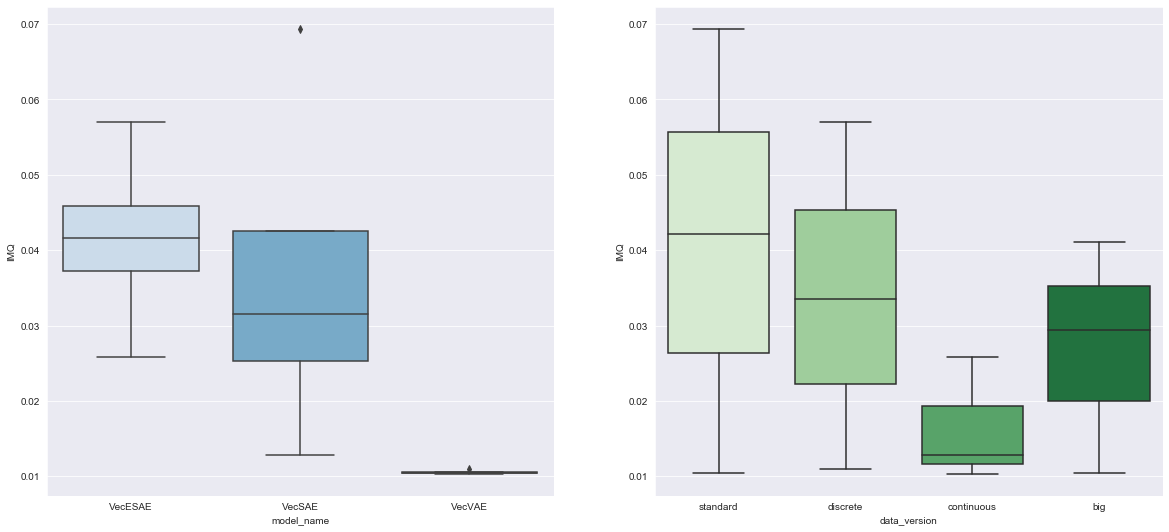

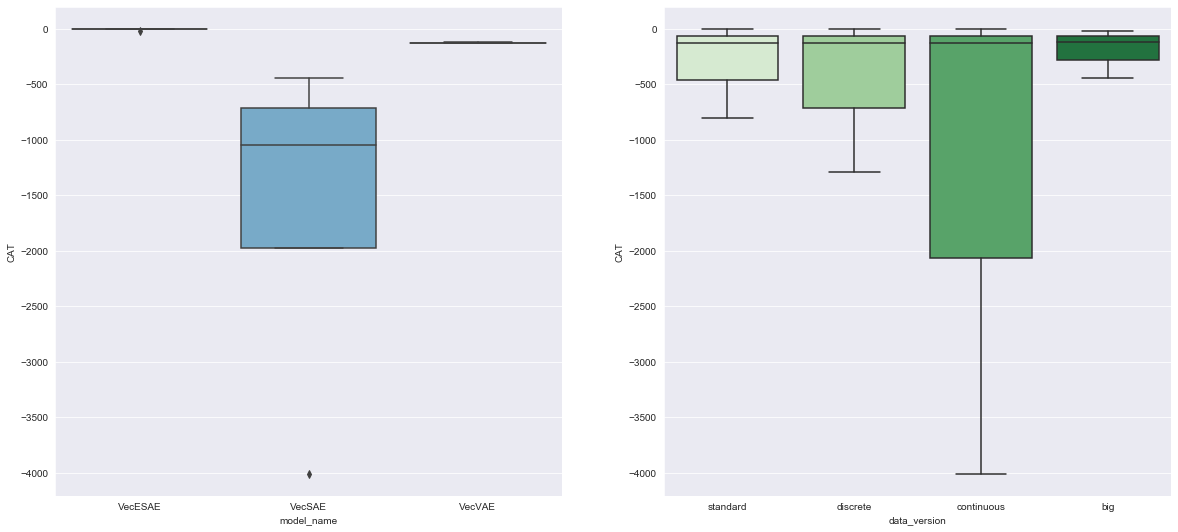

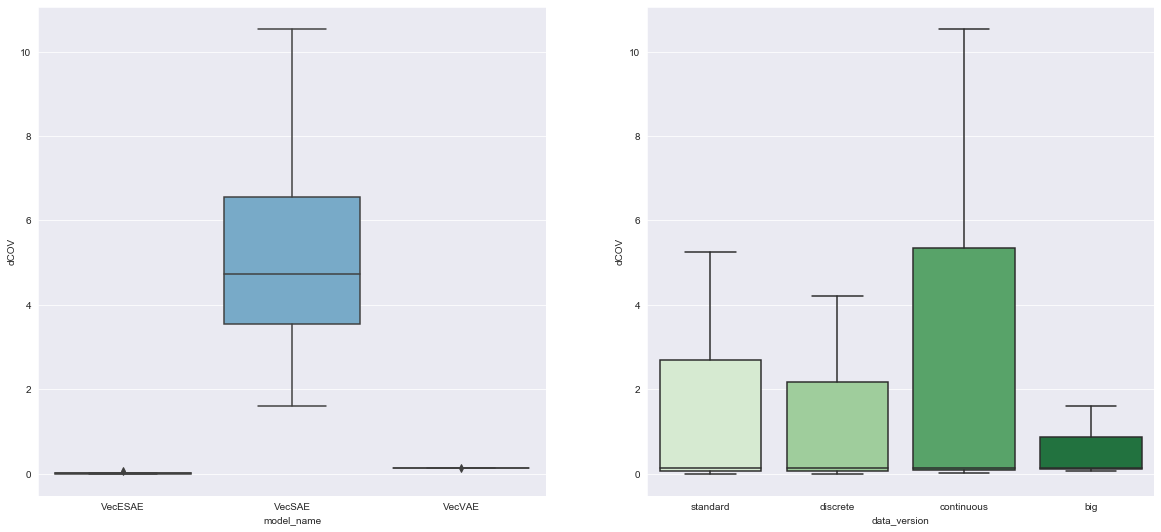

In [48]:
for k in scores_df.columns[2:6]: # orthogonality
    fig, axs = plt.subplots(ncols=2, figsize=(20,9))
    sns.boxplot(x='model_name',y=k,data=scores_df, ax=axs[0], palette="Blues")
    sns.boxplot(x='data_version',y=k,data=scores_df, ax=axs[1], palette="Greens")

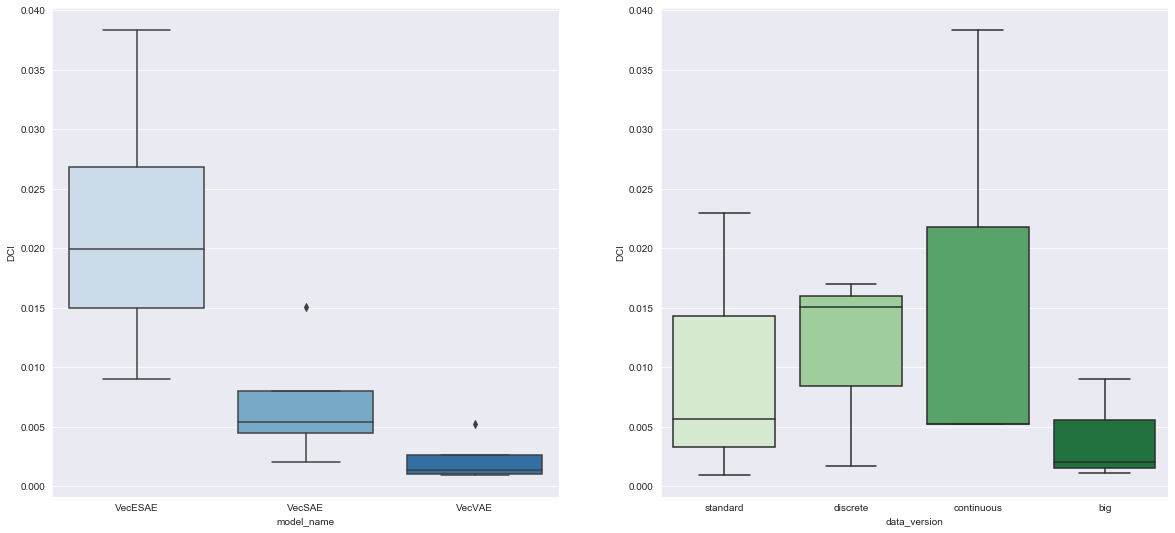

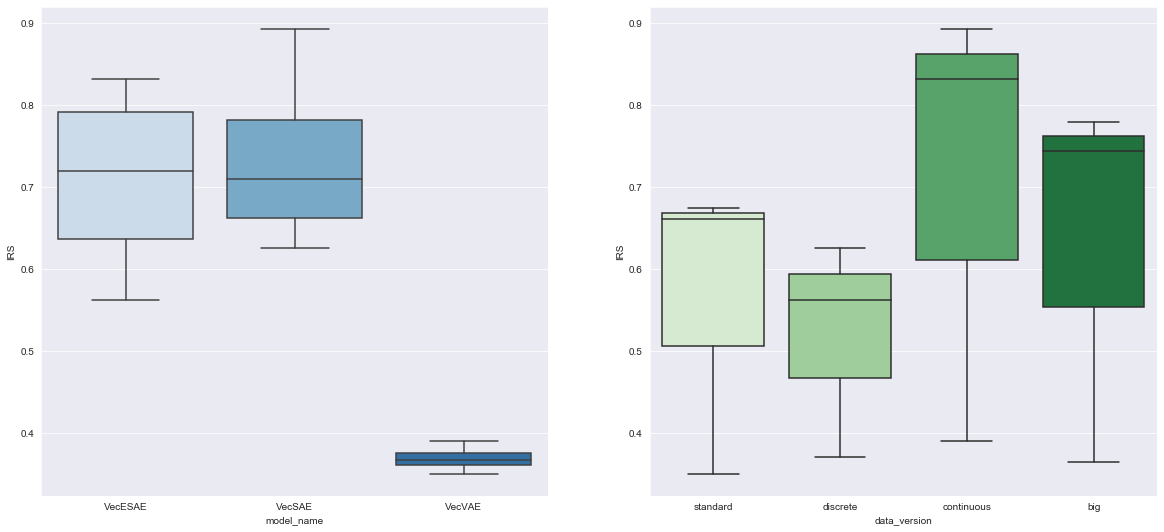

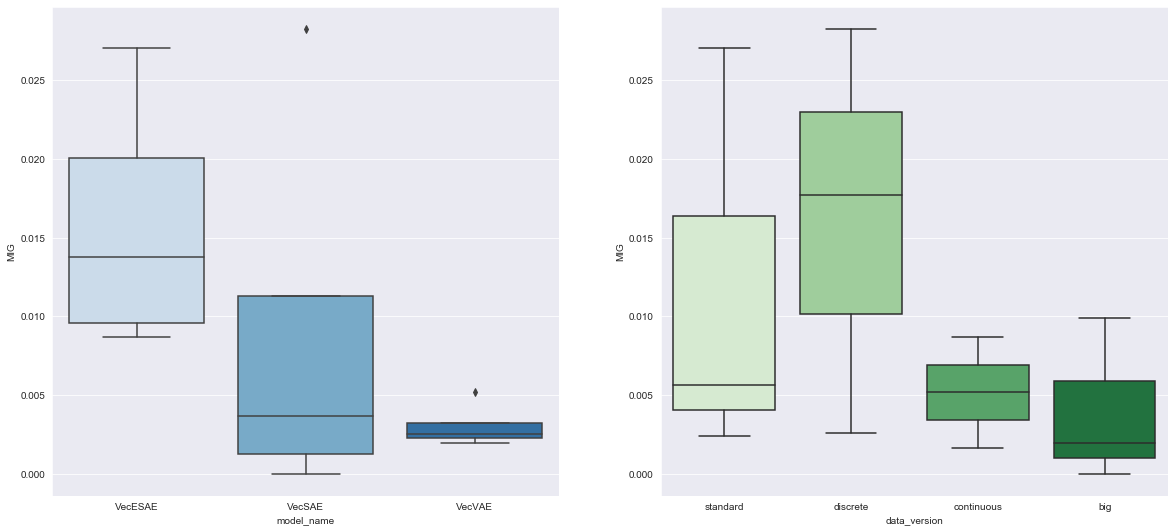

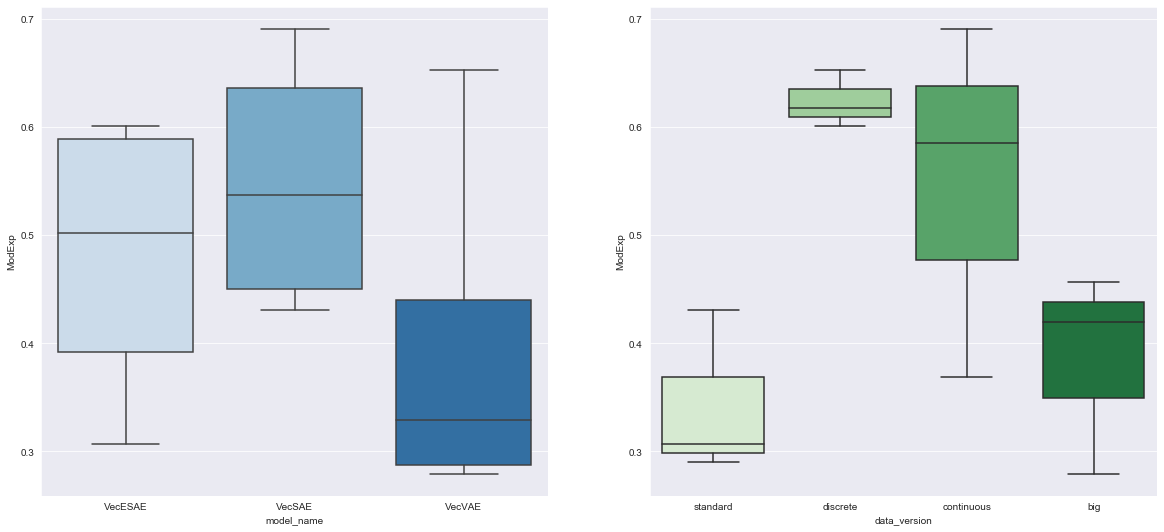

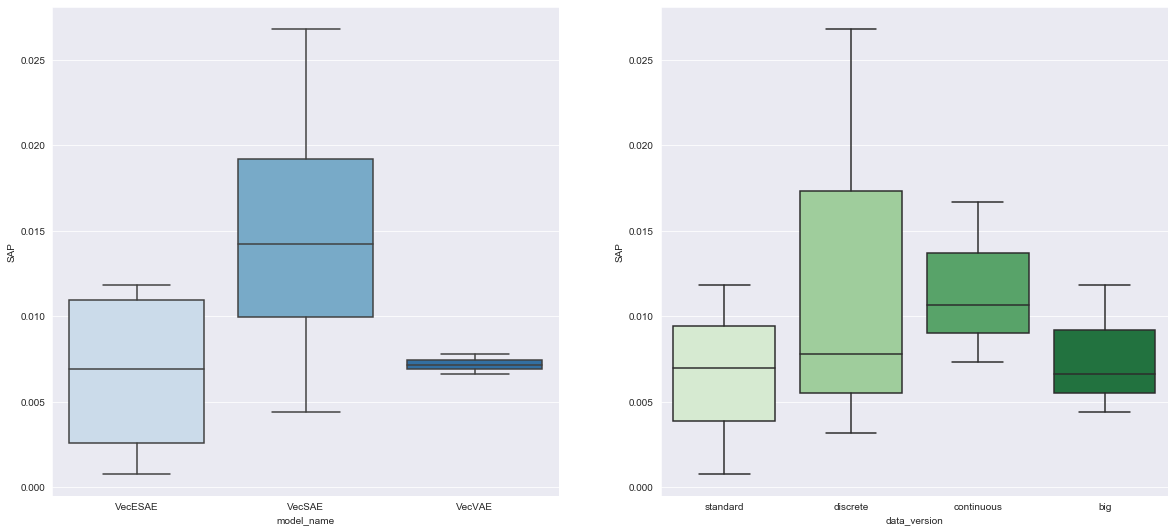

In [51]:
# finally visualising 
for k in scores_df.columns[6:]: # disentanglement
    fig, axs = plt.subplots(ncols=2, figsize=(20,9))
    sns.boxplot(x='model_name',y=k,data=scores_df, ax=axs[0], palette="Blues")
    sns.boxplot(x='data_version',y=k,data=scores_df, ax=axs[1], palette="Greens")